## Tools

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
import uOrfTools
from Sequence import DnaSequence
from Genome import Locus
from GenomeFactory import GenomeFactory
from CdtFile import CdtFile
import pandas as pd

In [ ]:
from random import shuffle, sample, seed
from Sequence import DnaSequence
from random import shuffle, sample, seed
import csv
import numpy as np

In [6]:
def save_ROC(fname, positives, negatives):
    out = csv.writer(open(fname,"w"))
    out.writerow(positives)
    out.writerow(negatives)
    del out

def load_ROC(fname):
    fin = csv.reader(open(fname))
    positives = [float(i) for i in next(fin)]
    negatives = [float(i) for i in next(fin)]
    return positives,negatives

In [7]:

orfList = load_ROC("uOrfTEATG.csv")

positiveOrf = orfList[0]
negativeOrf = orfList[1]

## Data

Load Sarah's data + genomes

In [8]:
(cdt, ti, ni1, ni2, ni3, ni4) = uOrfTools.load_TE_data()
(f, genome1, genome2, genome3, genome4) = uOrfTools.grabGenomes()

Filter for genes conserved across all 4 strains

In [9]:
(cdt3s, cdt3s_10) = uOrfTools.prepareCdt(cdt, ti, ni1, ni2, ni3, ni4)

Load Danny's data and filter for genes with RNA structure predictions

In [10]:
from csv import reader
raw1 = list(reader(open("/home/mvoorhie/ForAnnika/utr5_HcG217B_utrdata.csv")))
data1 = raw1[1:]
name2constrained = dict((i[0], float(i[2])) for i in data1 if(i[2] != "-2e+20"))
cdt3s = CdtFile.fromPrototype(
    cdt3s, probes = [row for row in cdt3s if (row.extra[ni3] in name2constrained)])

## Extract features for ML

In [11]:
#getting top five lengths of orfs for the 3819 genes used (some had less than five)
#using the G217B strain for fungi
def topNOrfs(cdt,ni,genome):
    """Traverses through the Histoplasma genome, finds up to 5 longest uORFs, 
       returns their lengths and locations as two lists"""
    lengths = []
    locations = []
    no_ORF = 0
    for histogene in cdt:
        gene = genome.getGene(histogene.extra[ni])
        try:
            (utr_five, utr_three) = gene.utr_seqs()

        except:
            # For genes with no ORF, 5' UTR is undefined
            # Report no uORF in this case
            lengths.append(0)
            no_ORF += 1
            continue
        x = []
        for(start, stop) in utr_five.disjoint_cds(startcodons = ["ATG"]):
            value = stop - start + 1
            x.append((value,start))
            
        x.sort(reverse = True)
        x_lengths = [0]*5
        x_locations = [0]*5
        for (n,i) in enumerate(x[:5]):
            x_lengths[n] = i[0]
            x_locations[n] = i[1]
        lengths.append(x_lengths)
        locations.append(x_locations)

        
    print "No ORF for %d genes" % no_ORF
    return lengths,locations
topLengths,locLengths = topNOrfs(cdt3s, ni3, genome3)
len(topLengths),len(locLengths)

No ORF for 0 genes


(4981, 4981)

In [12]:
topLengths[0]

[30, 18, 15, 9, 6]

In [13]:
#grabbing energy of constrained RNA structure in a list

Gfold = []
def getGFold(cdt):
    Gfold = []
    for row in cdt:
        gene_name = row.extra[ni3]
        if type(name2constrained) == "int":
            Gfold.append(name2constrained[gene_name] + 0.0)
        else:
            Gfold.append(float(name2constrained[gene_name]))
    return Gfold
Gfold = getGFold(cdt3s)
len(Gfold)

4981

In [14]:
#get UTR values
def findUtrLength(cdt,ni,genome, shuffling_control = False):
    """Traverses through the Histoplasma genome, finds uORFs, returns max length of uORFs"""
    lengths = []
    no_ORF = 0
    for histogene in cdt:
        gene = genome.getGene(histogene.extra[ni])
        try:
            (utr_five, utr_three) = gene.utr_seqs()
        except:
            # For genes with no ORF, 5' UTR is undefined
            # Report no uORF in this case
            lengths.append(0)
            no_ORF += 1
            continue
        lengths.append(len(utr_five))    
    print "No ORF for %d genes" % no_ORF
    return lengths
utrLengths = findUtrLength(cdt3s, ni3, genome3, shuffling_control = True)
len(utrLengths)

No ORF for 0 genes


4981

In [15]:
def probList():
    p_start = 1/64.
    p_cds = 61/64.0

    L = np.array(utrLengths, dtype = "float")
    n = np.array([i [0] for i in topLengths], dtype = "float")/3.
    #p_predictions = np.where(n != 0.0, -np.log(1-np.exp((L-3*n)*np.log(1-p_start*np.power(p_cds,n-2)))),0.0)
    p_predictions = -np.log(1-np.exp((L-3*n)*np.log(1-p_start*np.power(p_cds,n-2))))
    print type(p_predictions)
    return p_predictions
    #print len(p_predictions),p_predictions[:10]

In [ ]:
utrList = probList()
print utrList
print len(utrList)
newUtrLengths = []
nullValue = 0
for i in range(len(utrLengths)):
    newUtrLengths.append(utrList[i])
    if np.isinf(utrList[i]):
        nullValue += 1
        utrList[i] = 0.0
#print newUtrLengths  
print min(utrList)
print max(utrList)
print None in newUtrLengths
print nullValue
#uniqueValues, occurCount = np.unique(newUtrLengths, return_counts=True)
#print(uniqueValues, occurCount)
#np.nan_to_num(newUtrLengths)

In [17]:
TeValues = []
for row in cdt3s:
    TeValues.append(row[ti])
len(TeValues)

4981

In [18]:
gene_names = []
for row in cdt3s:
    gene_names.append(row.extra[ni3])
len(gene_names),gene_names[0]

(4981, 'ucsf_hc.01_1.G217B.08341')

<IPython.core.display.Javascript object>


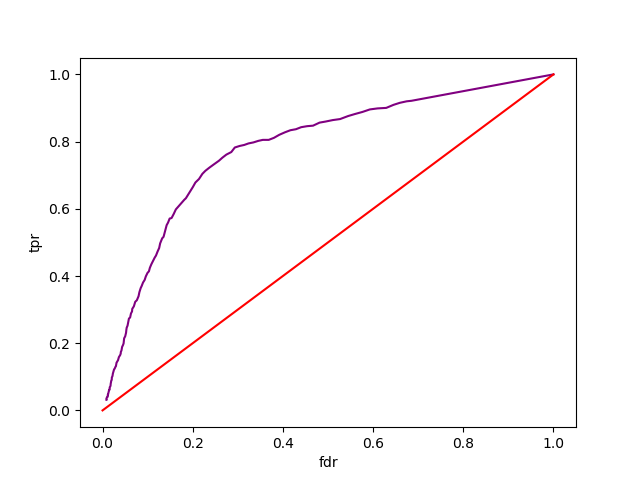

In [19]:
positives_ATG = []
negatives_ATG = []
X = [i[0] for i in topLengths]
for i in range(len(TeValues)):
    if (TeValues[i]) < -2:
        positives_ATG.append(X[i])
    elif (TeValues[i] <= 2 ):
        negatives_ATG.append(X[i])
        
fig = plt.figure()      
probPlot = uOrfTools.rocPlot(fig, positives_ATG, negatives_ATG, color = "purple")
fig.savefig("uOrfTEATG.png")
save_ROC("uOrfTEATG.csv",positives_ATG,negatives_ATG)


## Write features to CSV

In [20]:
def makeCsvFeatures5(orfLengths, rnaStructureLengths, utrLengths, locations, TEValues, gene_names):
    for i in (orfLengths, rnaStructureLengths, utrLengths, TEValues, gene_names):
        assert(len(i) == len(locations))
    with open('histoDataRegression5.csv', 'wb') as csvfile:
        filewriter = csv.writer(csvfile, delimiter = ',', quotechar = '|', quoting = csv.QUOTE_MINIMAL)
        filewriter.writerow([
                'Top five upstream Orf 1', 'Top five upstream Orf 2',
                             'Top five upstream Orf 3', 'Top five upstream Orf 4', 
                             'Top five upstream Orf 5', 
                             'Energy of Constrained RNA structure', 
                             'Location of uORF relative to 5 prime UTR 1', 'Location of uORF relative to 5 prime UTR 2',
                             'Location of uORF relative to 5 prime UTR 3', 'Location of uORF relative to 5 prime UTR 4',
                             'Location of uORF relative to 5 prime UTR 5', 
                             'Length of five prime UTR', 'Translation Efficiency Value'])
        for i in range(len(locations)):
            filewriter.writerow([gene_names[i],orfLengths[i][0], orfLengths[i][1],
                                 orfLengths[i][2], orfLengths[i][3],
                                 orfLengths[i][4], 
                                 rnaStructureLengths[i], 
                                 locations[i][0], locations[i][1],
                                 locations[i][2], locations[i][3],
                                 locations[i][4],  
                                 utrLengths[i], TEValues[i]])

testFile = makeCsvFeatures5(topLengths, Gfold, newUtrLengths, locLengths, TeValues, gene_names)

## Reload features in Pandas

In [21]:
import os
filename = 'histoDataRegression5.csv'
dfFrameList = []
for chunkTemp in pd.read_csv(filename, chunksize=20):
    dfFrameList.append(chunkTemp)
dataFrame = pd.concat(dfFrameList)
dataFrame.replace(np.Inf, np.nan, inplace= True)
dataFrame.replace(-np.Inf, np.nan, inplace= True)
dataFrame.fillna(0.0, inplace= True)
dataFrame.head(20)

,Top five upstream Orf 1,Top five upstream Orf 2,Top five upstream Orf 3,Top five upstream Orf 4,Top five upstream Orf 5,Energy of Constrained RNA structure,Location of uORF relative to 5 prime UTR 1,Location of uORF relative to 5 prime UTR 2,Location of uORF relative to 5 prime UTR 3,Location of uORF relative to 5 prime UTR 4,Location of uORF relative to 5 prime UTR 5,Length of five prime UTR,Translation Efficiency Value
ucsf_hc.01_1.G217B.08341,30,18,15,9,6,-17.698300,83,103,227,155,139,0.098716,-9.459208
ucsf_hc.01_1.G217B.01767,261,132,114,81,69,14.413700,255,251,832,773,979,1.322335,-9.243261
ucsf_hc.01_1.G217B.07048,228,198,129,105,96,14.296300,153,498,652,521,73,1.493679,-9.120387
ucsf_hc.01_1.G217B.11548,222,189,165,123,24,1.773460,634,482,510,825,326,0.925579,-9.107669
ucsf_hc.01_1.G217B.02546,219,126,117,93,75,-59.318400,1183,1464,1592,107,273,0.577659,-8.945603
ucsf_hc.01_1.G217B.01784,237,216,171,132,6,0.497907,43,374,143,463,598,1.935854,-8.912018
ucsf_hc.01_1.G217B.01685,528,225,186,156,99,-18.775000,7,669,425,745,275,6.323068,-8.737662
ucsf_hc.01_1.G217B.00078,132,84,84,15,0,-57.567100,438,620,274,592,0,0.267515,-8.710243
ucsf_hc.01_1.G217B.04529,0,0,0,0,0,-3.865590,0,0,0,0,0,0.287133,-8.571925
ucsf_hc.01_1.G217B.05111,192,183,171,162,144,88.780300,1067,27,1652,708,1829,0.261305,-8.490833


In [22]:
#Test the lengths of the data
len(utrLengths),len(topLengths)

(4981, 4981)

## Probabilistic model

In [23]:
#creating the probabilistic model



In [24]:
#sum(1 for i in p_predictions if(i>0))

In [25]:
# positives_prob = []
# negatives_prob = []
# for i in range(len(p_predictions)):
#     if (TeValues[i]) < -2:
#         positives_prob.append(p_predictions[i]*100)
#     elif (TeValues[i] <= 2 ):
#         negatives_prob.append(p_predictions[i]*100)
        
# #print(len(set(positives)), len(set(negatives)))
# fig = plt.figure()      
# probPlot = uOrfTools.rocPlot(fig, positives_prob, negatives_prob, color = "purple", tmin = -100, tmax = 1000)
# #fig

In [26]:
#save_ROC("ROC_probabilistic.csv",positives_prob,negatives_prob)

## ML

In [27]:
#Adding secondary attributes
dataFrame['Sum of Top 5 Orf'] = dataFrame['Top five upstream Orf 1'] +\
dataFrame['Top five upstream Orf 2'] +\
dataFrame['Top five upstream Orf 3'] +\
dataFrame['Top five upstream Orf 4'] +\
dataFrame['Top five upstream Orf 5']


dataFrame['ratio of sum length of 5 Orf to 5 prime UTR length'] = \
dataFrame['Sum of Top 5 Orf']/dataFrame['Length of five prime UTR']
dataFrame.replace(np.Inf, np.nan, inplace= True)
dataFrame.fillna(0, inplace = True)


#Reaarange colums so that Translational Efficiency is the last column
cols = dataFrame.columns.tolist()
cols = cols[-2:] + cols[:-2]
dataFrame = dataFrame[cols]
cols = dataFrame.columns.tolist()
print cols

['Sum of Top 5 Orf', 'ratio of sum length of 5 Orf to 5 prime UTR length', 'Top five upstream Orf 1', 'Top five upstream Orf 2', 'Top five upstream Orf 3', 'Top five upstream Orf 4', 'Top five upstream Orf 5', 'Energy of Constrained RNA structure', 'Location of uORF relative to 5 prime UTR 1', 'Location of uORF relative to 5 prime UTR 2', 'Location of uORF relative to 5 prime UTR 3', 'Location of uORF relative to 5 prime UTR 4', 'Location of uORF relative to 5 prime UTR 5', 'Length of five prime UTR', 'Translation Efficiency Value']


In [28]:
#Look at correlation
corr_matrix = dataFrame.corr()
print corr_matrix['Translation Efficiency Value'].sort_values(ascending=False)

Translation Efficiency Value                          1.000000
ratio of sum length of 5 Orf to 5 prime UTR length    0.018988
Energy of Constrained RNA structure                  -0.009268
Length of five prime UTR                             -0.223368
Location of uORF relative to 5 prime UTR 1           -0.245828
Location of uORF relative to 5 prime UTR 3           -0.275782
Location of uORF relative to 5 prime UTR 4           -0.281989
Location of uORF relative to 5 prime UTR 2           -0.286578
Location of uORF relative to 5 prime UTR 5           -0.311224
Top five upstream Orf 1                              -0.331917
Top five upstream Orf 5                              -0.387070
Top five upstream Orf 4                              -0.406563
Top five upstream Orf 2                              -0.411572
Sum of Top 5 Orf                                     -0.416300
Top five upstream Orf 3                              -0.428878
Name: Translation Efficiency Value, dtype: float64


In [29]:
dataFrame.head(20)

,Sum of Top 5 Orf,ratio of sum length of 5 Orf to 5 prime UTR length,Top five upstream Orf 1,Top five upstream Orf 2,Top five upstream Orf 3,Top five upstream Orf 4,Top five upstream Orf 5,Energy of Constrained RNA structure,Location of uORF relative to 5 prime UTR 1,Location of uORF relative to 5 prime UTR 2,Location of uORF relative to 5 prime UTR 3,Location of uORF relative to 5 prime UTR 4,Location of uORF relative to 5 prime UTR 5,Length of five prime UTR,Translation Efficiency Value
ucsf_hc.01_1.G217B.08341,78,790.147021,30,18,15,9,6,-17.698300,83,103,227,155,139,0.098716,-9.459208
ucsf_hc.01_1.G217B.01767,657,496.848254,261,132,114,81,69,14.413700,255,251,832,773,979,1.322335,-9.243261
ucsf_hc.01_1.G217B.07048,756,506.132685,228,198,129,105,96,14.296300,153,498,652,521,73,1.493679,-9.120387
ucsf_hc.01_1.G217B.11548,723,781.132694,222,189,165,123,24,1.773460,634,482,510,825,326,0.925579,-9.107669
ucsf_hc.01_1.G217B.02546,630,1090.609645,219,126,117,93,75,-59.318400,1183,1464,1592,107,273,0.577659,-8.945603
ucsf_hc.01_1.G217B.01784,762,393.624788,237,216,171,132,6,0.497907,43,374,143,463,598,1.935854,-8.912018
ucsf_hc.01_1.G217B.01685,1194,188.832387,528,225,186,156,99,-18.775000,7,669,425,745,275,6.323068,-8.737662
ucsf_hc.01_1.G217B.00078,315,1177.504724,132,84,84,15,0,-57.567100,438,620,274,592,0,0.267515,-8.710243
ucsf_hc.01_1.G217B.04529,0,0.000000,0,0,0,0,0,-3.865590,0,0,0,0,0,0.287133,-8.571925
ucsf_hc.01_1.G217B.05111,852,3260.558147,192,183,171,162,144,88.780300,1067,27,1652,708,1829,0.261305,-8.490833


In [30]:
#testing to see if I can access a value in the data frame
dataFrame.loc["ucsf_hc.01_1.G217B.08341",['Translation Efficiency Value']].values

array([-9.45920804])

## Decision Tree

In [31]:
#testing
#taking all features
#Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor, _tree

#Get all the features i.e. all the columns names
finalCols = dataFrame.columns
#Take all columns names of features except last column name which has label
finalFeatures = finalCols[:-1]
# Get values of all features
x = dataFrame.loc[:, finalFeatures].values
# Get all values of the label
y = dataFrame.loc[:,['Translation Efficiency Value']].values


#Stanardize the data because the scales of the features have a large range
scaler = StandardScaler().fit(x)
x_std_data = scaler.transform(x)
#y_std_data = StandardScaler().fit_transform(y)
y_std_data = y

#Split data into test and train
x_train, x_test, y_train, y_test = train_test_split(x_std_data, y_std_data, test_size = 0.2)

#Decision tree regressor
tree_model = DecisionTreeRegressor(max_depth=2)
tree_model.fit(x_train, y_train)

#Just look at the training metrics by using the model to predicting on itself
y_train_predictions = tree_model.predict(x_train)
print("Mean absolute error-training data: %0.2f" % mean_absolute_error(y_train, y_train_predictions))
print("Mean squared error-training data: %0.2f" % mean_squared_error(y_train, y_train_predictions))
print("Root mean squared error-training data: %0.2f" % np.sqrt(mean_squared_error(y_train, y_train_predictions)))
print("R2 score-training data: %0.2f" % r2_score(y_train, y_train_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-training data : %0.2f" % explained_variance_score(y_train, y_train_predictions))

#Do the predictions on test data and check the metrics
y_predictions = tree_model.predict(x_test)
print("Mean absolute error-test data : %0.2f" % mean_absolute_error(y_test, y_predictions))
print("Mean squared error-test data : %0.2f" % mean_squared_error(y_test, y_predictions))
print("Root mean squared error-test data : %0.2f" % np.sqrt(mean_squared_error(y_test, y_predictions)))
print("R2 score-test data : %0.2f" % r2_score(y_test, y_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-test data : %0.2f" % explained_variance_score(y_test, y_predictions))

#Do Predictions on the entire data and check the metrics
tree_model.fit(x_std_data, y_std_data)
y_whole_predictions = tree_model.predict(x_std_data)
print("Mean absolute error-whole data: %0.2f" % mean_absolute_error(y_std_data, y_whole_predictions))
print("Mean squared error-whole data: %0.2f" % mean_squared_error(y_std_data, y_whole_predictions))
print("Root mean squared error-whole data: %0.2f" % np.sqrt(mean_squared_error(y_std_data, y_whole_predictions)))
print("R2 score-training data: %0.2f" % r2_score(y_std_data, y_whole_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-training data : %0.2f" % explained_variance_score(y_std_data, y_whole_predictions))



#getting the nodes
#TODO - modify the code
#https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
#Trying another Stack Overflow Code
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {"
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print "} else {"
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print "}"
                else:
                        print "return " + str(value[node])

        recurse(left, right, threshold, features, 0)


get_code(tree_model, finalCols)


print(tree_model.get_params())
#print(tree_model.decision_path(x_train))

#Compare the predicted values with real values
df = pd.DataFrame({'Actual':y_test.flatten(),'Predicted':y_predictions.flatten()})
print df

Mean absolute error-training data: 1.20
Mean squared error-training data: 2.85
Root mean squared error-training data: 1.69
R2 score-training data: 0.20
Explained variance score-training data : 0.20
Mean absolute error-test data : 1.15
Mean squared error-test data : 2.63
Root mean squared error-test data : 1.62
R2 score-test data : 0.24
Explained variance score-test data : 0.24
Mean absolute error-whole data: 1.18
Mean squared error-whole data: 2.80
Root mean squared error-whole data: 1.67
R2 score-training data: 0.21
Explained variance score-training data : 0.21
if ( Sum of Top 5 Orf <= 0.612540245056 ) {
if ( Top five upstream Orf 2 <= -0.483657419682 ) {
return [[ 0.20202037]]
} else {
return [[-0.47612214]]
}
} else {
if ( Top five upstream Orf 5 <= 1.5801845789 ) {
return [[-1.58824847]]
} else {
return [[-2.62448795]]
}
}
{'presort': False, 'splitter': 'best', 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_

<IPython.core.display.Javascript object>


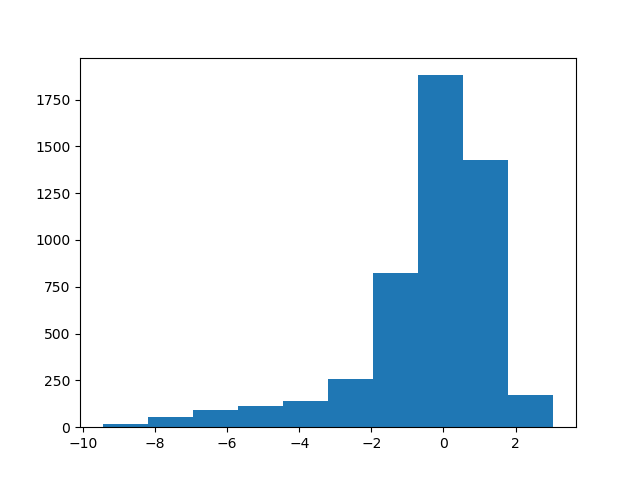

<IPython.core.display.Javascript object>


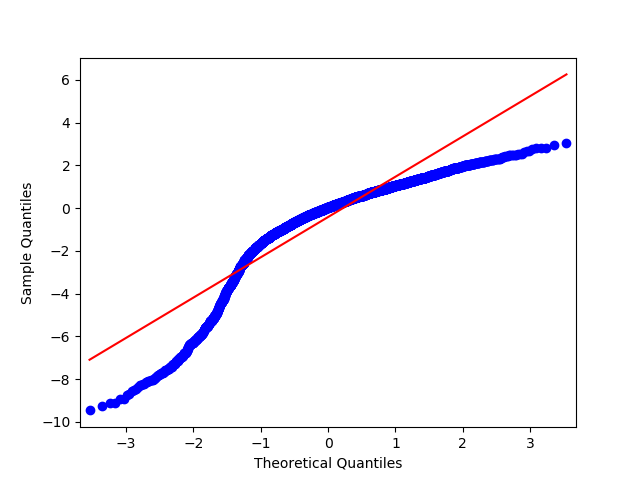

,0
count,4981.000000
mean,-0.421339
std,1.884872
min,-9.459208
25%,-0.988428
50%,0.035501
75%,0.756062
max,3.051594


In [32]:
fig=plt.figure()
from matplotlib import pyplot
y2 = y
#y2 = 1/np.log(np.sqrt(y2+10))
pyplot.hist(y2)
fig
from statsmodels.graphics.gofplots import qqplot
qqplot(y2, line='s')
fig
dfy2 = pd.DataFrame(y2)
dfy2.describe()
# from scipy.stats import normaltest
# stat, p = normaltest(y)
# print ('statistics=%.3f, p=%.3f' %(stat,p))

### ROC for test set

In [33]:
y_test = y_test.flatten()
y_train = y_train.flatten()
y_predictions = y_predictions.flatten()
y_train_predictions = y_train_predictions.flatten()

<IPython.core.display.Javascript object>


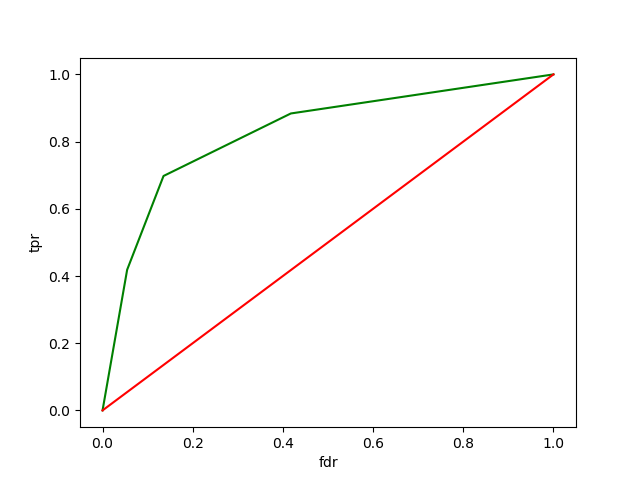

In [34]:
#testing
#ROC plot for Decision Tree Regressor 
fig = plt.figure()
positivesTree = []
negativesTree = []

for i in range(len(y_predictions)):
    if (y_test[i]) < -2:
        positivesTree.append(-y_predictions[i]*100)
    elif (y_test[i] <= 2):
        negativesTree.append(-y_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
treePlot = uOrfTools.rocPlot(fig, positivesTree, negativesTree, color = "green", tmin = -100, tmax = 700)
save_ROC("ROC_dTree.csv",positivesTree,negativesTree)
fig.savefig("rocTreeTest.png")
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

### ROC for training set

<IPython.core.display.Javascript object>


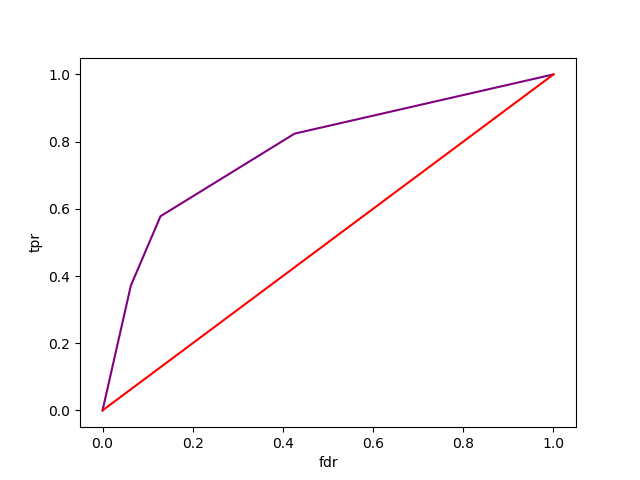

In [35]:
#testing
#ROC plot for Decision Tree Regressor 
fig = plt.figure()
positivesTree = []
negativesTree = []

for i in range(len(y_train_predictions)):
    if (y_train[i]) < -2:
        positivesTree.append(-y_train_predictions[i]*100)
    elif (y_train[i] <= 2):
        negativesTree.append(-y_train_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
treePlot = uOrfTools.rocPlot(fig, positivesTree, negativesTree, color = "purple", tmin = -100, tmax = 700)
save_ROC("ROC_dTree.train.csv",positivesTree,negativesTree)
fig.savefig("rocTreeTrain.png")
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

### ROC plot for full data

<IPython.core.display.Javascript object>


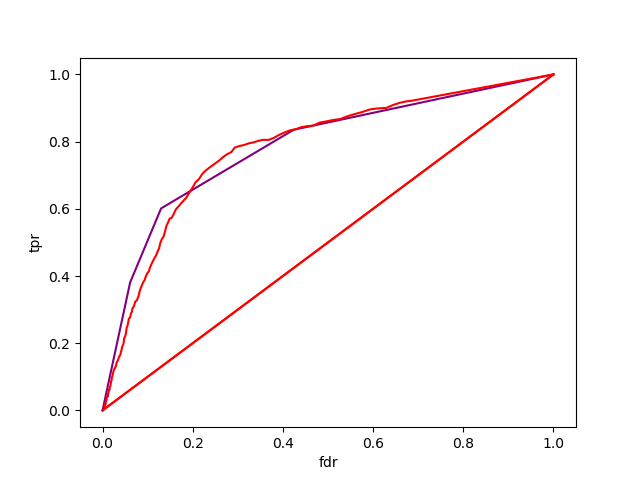

In [36]:
#testing
#ROC plot for Decision Tree Regressor 
fig = plt.figure()
positivesTree = []
negativesTree = []

X = np.hstack((y_train,y_test))
Y = np.hstack((y_train_predictions,y_predictions))

for i in range(len(X)):
    if (X[i]) < -2:
        positivesTree.append(-Y[i]*100)
    elif (X[i] <= 2):
        negativesTree.append(-Y[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
treePlot = uOrfTools.rocPlot(fig, positivesTree, negativesTree, color = "purple", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positiveOrf, negativeOrf, color = "red", tmin = -100, tmax = 700)

fig.savefig("rocTreeAll.png")
save_ROC("ROC_dTree.full.csv",positivesTree,negativesTree)
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

In [37]:
def fdrPlot(fig,positives, negatives, color = "gray",
            tmin = 0, tmax = 500, tstep = 1, marker = "None"):
    totalPositives = float(len(positives))
    totalNegatives = float(len(negatives))
    fdr = []
    thresh = []
    for threshold in range(tmin,tmax+1, tstep):
        #TODO set counter variables
        tp = 0
        fp = 0
        for i in range(len(positives)):
            if positives[i] >= threshold:
                tp = tp + 1
                
        for i in range(len(negatives)):
            if negatives[i] >= threshold:
                fp = fp + 1

        fdRate = fp/totalNegatives
        fdr.append(fdRate)
        thresh.append(threshold)
        
    
    roc_plot = plt.plot(fdr, thresh, color=color,marker=marker)
    plt.xlabel("fdr")
    plt.ylabel("threshold")
    return fig



<IPython.core.display.Javascript object>


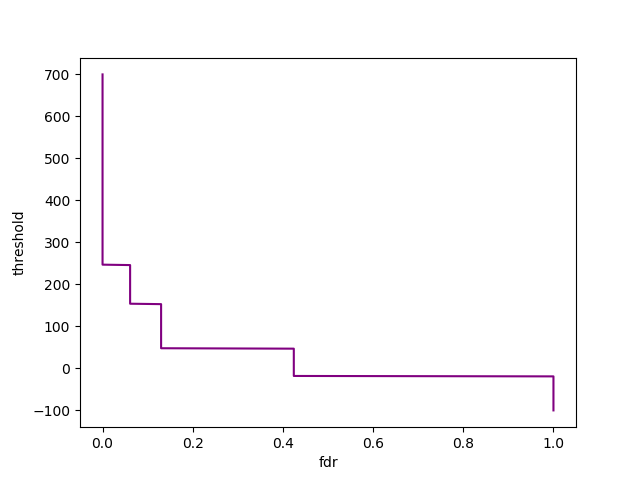

In [38]:
fig = plt.figure()
fig_fp = fdrPlot(fig, positivesTree, negativesTree, color = "purple", tmin = -100, tmax = 700)

In [39]:
# Based on the sklearn documentation: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

from Colors import ColorServer
cs = ColorServer()
feature_colors = [cs[i] for i in finalFeatures]

class MyTree:
    def __init__(self, t_children_left,t_children_right,t_threshold,t_feature,t_value, feature_names, 
                 feature_colors, p_thresh=1):
        self.children_left = t_children_left
        self.children_right = t_children_right
        self.threshold = t_threshold
        self.feature = t_feature
        self.value = t_value
        self.feature_names = feature_names
        self.feature_colors = feature_colors
        self.p_thresh = p_thresh
        
    @classmethod
    def fromDT(cls, tree, feature_names, feature_colors, p_thresh = 1):
        t = tree.tree_
        return cls(t.children_left,t.children_right,t.threshold,t.feature,[i[0][0] for i in t.value], feature_names, 
                 feature_colors, p_thresh)
        
    def node_label(self, n):
        if(self.children_left[n] == self.children_right[n]):
            # Leaf node
            return "%d: %3.2f" % (n, self.value[n])
        
        # Internal node
        return "%d: %s <= %3.2f" % (n, self.feature_names[self.feature[n]], self.threshold[n])
        
    def to_graphviz(self):
        node_properties = ""
        s = 'digraph G{\nrankdir="LR";\n'
        for (n,(left,right)) in enumerate(zip(self.children_left, self.children_right)):
            if(left == right):
                # Leaf node
                if(self.value[n] < self.p_thresh):
                    color = "red"
                else:
                    color = "green"
                node_properties += '"%s" [style=filled fillcolor=%s];\n' % (self.node_label(n),color)
            else:
                # Internal node
                parent = self.node_label(n)
                s += '  "%s" -> "%s" [label="yes"];\n' % (parent, self.node_label(left))
                s += '  "%s" -> "%s" [label="no"];\n' % (parent, self.node_label(right))
                node_properties += '"%s" [style=filled fillcolor="%s"];\n' % (parent, 
                                                                              self.feature_colors[self.feature[n]])
        s += node_properties+"}\n"
        return s
    

In [40]:
tree = MyTree.fromDT(tree_model, finalFeatures, feature_colors, p_thresh=-2.32)

In [41]:
open("DT_2_32.dot","w").write(tree.to_graphviz())

In [42]:
!dot -Tpng DT_2_32.dot > DT_2_32.png

In [43]:
from IPython.core.display import Image

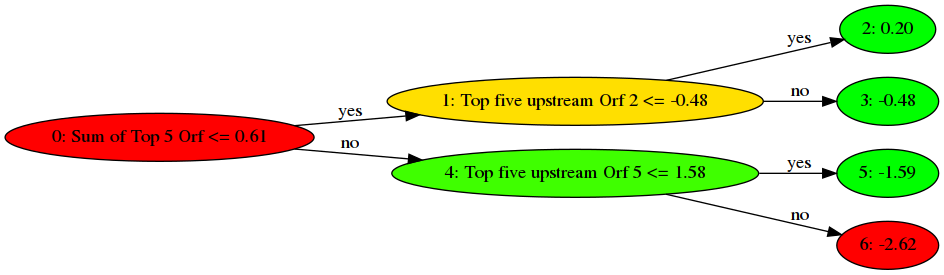

In [44]:
Image(filename="DT_2_32.png")

In [45]:
# x_values = ('Top five upstream Orf 1', 'Top five upstream Orf 2',
#                              'Top five upstream Orf 3', 'Top five upstream Orf 4', 
#                              'Top five upstream Orf 5', 
#                              'Energy of Constrained RNA structure', 
#                              'Location of uORF relative to 5 prime UTR 1', 'Location of uORF relative to 5 prime UTR 2',
#                              'Location of uORF relative to 5 prime UTR 3', 'Location of uORF relative to 5 prime UTR 4',
#                              'Location of uORF relative to 5 prime UTR 5', 
#                              'Length of five prime UTR')
# y_pos = np.arange(len(x_values))
# print y_pos
# print type(y_pos) 
# #y_values = model.coef_[0] * 100000
# #print y_values
# #print tree_model.coef_ * 100000
# fig = plt.figure()
# plt.bar(range(tree_model.coef_.shape[1]), tree_model.coef[0])
# plt.xlabel('Features of the Algorithm')
# plt.ylabel('Value of the Coefficients')
# plt.savefig('treeBar.png')


## Linear Regression

In [46]:
#Linear Regression - Proper code starts here
from sklearn.linear_model import LinearRegression

#Get all the features i.e. all the columns names
finalCols = dataFrame.columns
#Take all columns names of features except last column name which has label
finalFeatures = finalCols[:-1]
# Get values of all features
x = dataFrame.loc[:, finalFeatures].values
# Get all values of the label
y = dataFrame.loc[:,['Translation Efficiency Value']].values


#Standardize the data because the scales of the features have a large range
scaler = StandardScaler().fit(x)
x_std_data = scaler.transform(x)
#y_std_data = StandardScaler().fit_transform(y)
y_std_data = y

#Split data into test and train
x_train, x_test, y_train, y_test = train_test_split(x_std_data, y_std_data, test_size = 0.2)

#Try polynomial regression, so have to first make the features polynomial
#reverted to degree=1 as higher degrees gives worse metrics
poly_reg = PolynomialFeatures(degree = 1)
x_poly = poly_reg.fit_transform(x_train)
x_test_poly = poly_reg.fit_transform(x_test)

#Linear Regression
model = LinearRegression(normalize = True, fit_intercept=True)
model.fit(x_poly, y_train)
print "model coefficients for train data"
print(model.coef_)

#Just look at the training metrics by using the model to predicting on itself
y_train_predictions = model.predict(x_poly)
print("Mean absolute error-training data: %0.2f" % mean_absolute_error(y_train, y_train_predictions))
print("Mean squared error-training data: %0.2f" % mean_squared_error(y_train, y_train_predictions))
print("Root mean squared error-training data: %0.2f" % np.sqrt(mean_squared_error(y_train, y_train_predictions)))
print("R2 score-training data: %0.2f" % r2_score(y_train, y_train_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-training data : %0.2f" % explained_variance_score(y_train, y_train_predictions))


#Predict on test data
y_predictions = model.predict(x_test_poly)
print("Mean absolute error-test data: %0.2f" % mean_absolute_error(y_test, y_predictions))
print("Mean squared error-test data : %0.2f" % mean_squared_error(y_test, y_predictions))
print("Root mean squared error-test data : %0.2f" % np.sqrt(mean_squared_error(y_test, y_predictions)))
print("R2 score-test data : %0.2f" % r2_score(y_test, y_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-test data : %0.2f" % explained_variance_score(y_test, y_predictions))

#Do Predictions on the entire data and check the metrics
model.fit(x_std_data, y_std_data)
y_whole_predictions = model.predict(x_std_data)
print "model coefficients for whole data"
print(model.coef_)
print("Mean absolute error-whole data: %0.2f" % mean_absolute_error(y_std_data, y_whole_predictions))
print("Mean squared error-whole data: %0.2f" % mean_squared_error(y_std_data, y_whole_predictions))
print("Root mean squared error-whole data: %0.2f" % np.sqrt(mean_squared_error(y_std_data, y_whole_predictions)))
print("R2 score-training data: %0.2f" % r2_score(y_std_data, y_whole_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-training data : %0.2f" % explained_variance_score(y_std_data, y_whole_predictions))

df = pd.DataFrame({'Actual':y_test.flatten(),'Predicted':y_predictions.flatten()})
print df.head(20)
#check to what extent weights are most prominent
#throw out the factors it is not making use on
#do we do as well


model coefficients for train data
[[  0.00000000e+00  -7.34646721e+10   2.75253294e-02   3.35156747e+10
    1.75704258e+10   1.23563563e+10   9.66880940e+09   7.74306166e+09
   -2.05085595e-02  -2.91122302e-03  -1.71762715e-02   2.86966818e-02
    9.49784347e-02  -7.01931063e-02  -8.09266274e-02]]
Mean absolute error-training data: 1.19
Mean squared error-training data: 2.83
Root mean squared error-training data: 1.68
R2 score-training data: 0.19
Explained variance score-training data : 0.19
Mean absolute error-test data: 1.21
Mean squared error-test data : 3.03
Root mean squared error-test data : 1.74
R2 score-test data : 0.18
Explained variance score-test data : 0.18
model coefficients for whole data
[[  2.46601225e+11   2.42839256e-02  -1.12503142e+11  -5.89792129e+10
   -4.14769782e+10  -3.24556032e+10  -2.59913839e+10  -5.31755704e-02
   -3.55956687e-03  -2.36993126e-02   4.16701093e-02   1.24768181e-01
   -6.38231377e-02  -4.12757550e-02]]
Mean absolute error-whole data: 1.19
Mea

### ROC plot for test set

In [47]:
y_test = y_test.flatten()
y_train = y_train.flatten()
y_predictions = y_predictions.flatten()
y_train_predictions = y_train_predictions.flatten()

<IPython.core.display.Javascript object>


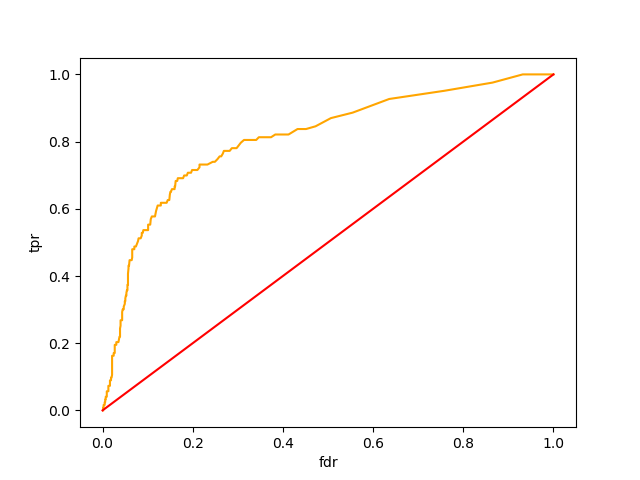

123
851


In [48]:
#linear regression roc plot
fig = plt.figure()
positives = []
negatives = []

for i in range(len(y_predictions)):
    if (y_test[i] < -2):
        #Question for Dr. Voorhies: why should I take -ve of y_predictions
        positives.append(-y_predictions[i]*100)
    elif (y_test[i] <=2):
        negatives.append(-y_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
print len(positives)
print len(negatives)
        
linearPlot = uOrfTools.rocPlot(fig, positives, negatives, color = "orange", tmin = -100, tmax = 700)
fig.savefig("rocLinearTest.png")
save_ROC("ROC_linear.csv",positives,negatives)

### ROC plot for training set

<IPython.core.display.Javascript object>


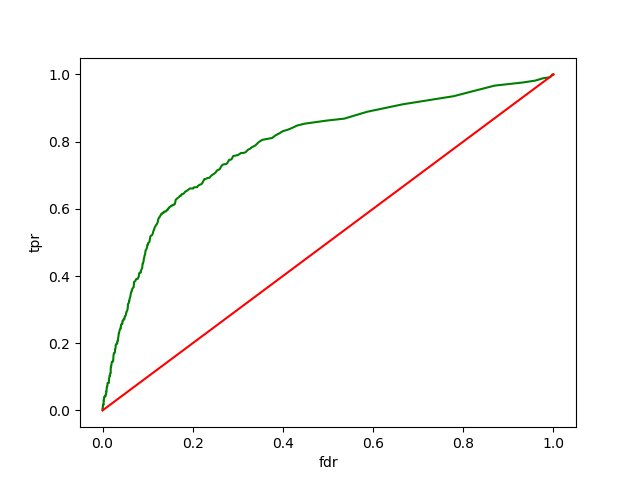

539
3369


In [49]:
#linear regression roc plot
fig = plt.figure()
positives = []
negatives = []

for i in range(len(y_train_predictions)):
    if (y_train[i] < -2):
        #Question for Dr. Voorhies: why should I take -ve of y_predictions
        positives.append(-y_train_predictions[i]*100)
    elif (y_train[i] <=2):
        negatives.append(-y_train_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
print len(positives)
print len(negatives)
        
linearPlot = uOrfTools.rocPlot(fig, positives, negatives, color = "green", tmin = -100, tmax = 700)
fig.savefig("rocLinearTraining.png")
save_ROC("ROC_linear.train.csv",positives,negatives)

<IPython.core.display.Javascript object>


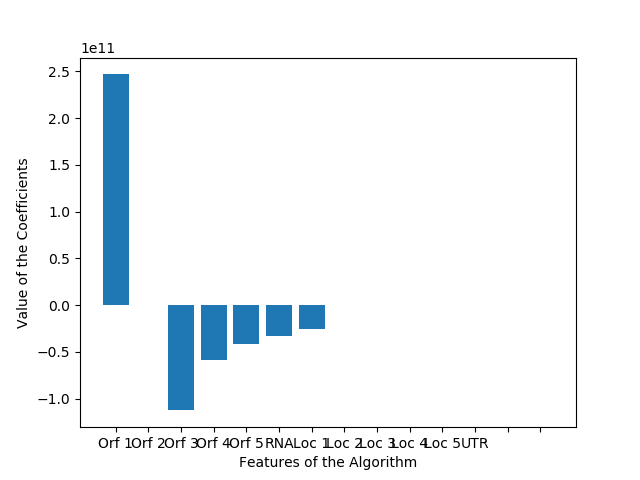

In [50]:
x_values = ('Orf 1', 'Orf 2',
                             'Orf 3', 'Orf 4', 
                             'Orf 5', 
                             'RNA', 
                             'Loc 1', 'Loc 2',
                             'Loc 3', 'Loc 4',
                             'Loc 5', 
                             'UTR')
# y_pos = np.arange(len(x_values))
# print y_pos
# print type(y_pos) 
# y_values = model.coef_[0]
# print y_values
# print model.coef_ * 100000
fig = plt.figure()
plt.bar(range(model.coef_.shape[1]), model.coef_[0])
plt.xticks(range(model.coef_.shape[1]), x_values)
#plt.xticks(y_pos, x_values)
plt.xlabel('Features of the Algorithm')
plt.ylabel('Value of the Coefficients')
plt.savefig('linearBar.png')


### ROC plot for all genes

<IPython.core.display.Javascript object>


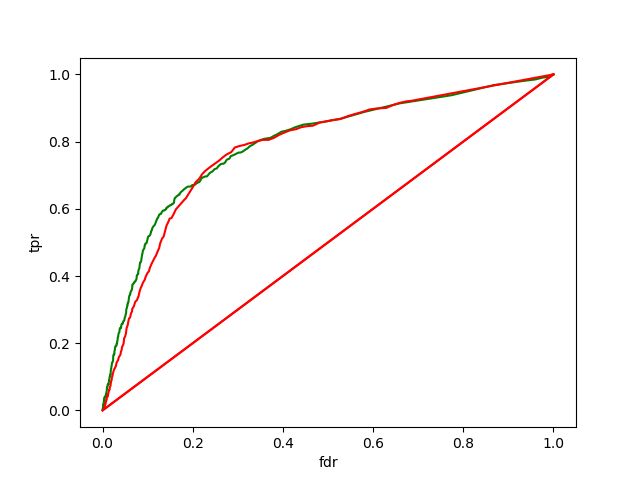

In [51]:
#linear regression roc plot
fig = plt.figure()
positives = []
negatives = []
X = np.hstack((y_train,y_test))
Y = np.hstack((y_train_predictions,y_predictions))

for i in range(len(X)):
    if (X[i] < -2):
        #Question for Dr. Voorhies: why should I take -ve of y_predictions
        positives.append(-Y[i]*100)
    elif (X[i] <=2):
        negatives.append(-Y[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
#print len(positives)
#print len(negatives)
        
forestPlot = uOrfTools.rocPlot(fig, positives, negatives, color = "green", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positiveOrf, negativeOrf, color = "red", tmin = -100, tmax = 700)
fig.savefig("rocLinearAllATG.png")
save_ROC("ROC_linear.full.csv",positives,negatives)

## Lasso Regression

In [52]:
#Lasso regression 
#REDO WITH CORRECT ALPHA VALUE
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, r2_score, explained_variance_score
import numpy as np
import pandas as pd

#Get all the features i.e. all the columns names
finalCols = dataFrame.columns
#Take all columns names of features except last column name which has label
finalFeatures = finalCols[:-1]
# Get values of all features
x = dataFrame.loc[:, finalFeatures].values
# Get all values of the label
y = dataFrame.loc[:,['Translation Efficiency Value']].values

print finalFeatures

#Standardize the data because the scales of the features have a large range
scaler = StandardScaler().fit(x)
x_std_data = scaler.transform(x)
#y_std_data = StandardScaler().fit_transform(y)
y_std_data = y

#Split data into test and train
x_train, x_test, y_train, y_test = train_test_split(x_std_data, y_std_data, test_size = 0.2)

#check to what extent weights are most prominent
#throw out the factors it is not making use on
#do we do as well
#Try LassoCV
#Lasso regression
#Lasso is a type of Linear Regression
#uses shrinkage, where data values are shrunk towards a central data point, ex. mean
#well-suite for models with multicollinearity
#performs L1 regularization, adds penalty equal to abs value of coefs
#which means some coefs can be zeroes
from sklearn.linear_model import LassoCV
lassoCV_model = LassoCV(cv=5, random_state=0, max_iter=10000)
lassoCV_model.fit(x_train, y_train)
print('Train data coefficients', lassoCV_model.coef_)
print('Train data alpha', lassoCV_model.alpha_)
print lassoCV_model

#Just look at the training metrics by using the model to predicting on itself
y_train_predictions = lassoCV_model.predict(x_train)
print("Mean absolute error-training data: %0.2f" % mean_absolute_error(y_train, y_train_predictions))
print("Mean squared error-training data: %0.2f" % mean_squared_error(y_train, y_train_predictions))
print("Root mean squared error-training data: %0.2f" % np.sqrt(mean_squared_error(y_train, y_train_predictions)))
print("R2 score-training data: %0.2f" % r2_score(y_train, y_train_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-training data : %0.2f" % explained_variance_score(y_train, y_train_predictions))
#print('Train coefficients:', lassoCV_model.coef_)

#Predict on test data
y_predictions = lassoCV_model.predict(x_test)
print("Mean absolute error-test data: %0.2f" % mean_absolute_error(y_test, y_predictions))
print("Mean squared error-test data : %0.2f" % mean_squared_error(y_test, y_predictions))
print("Root mean squared error-test data : %0.2f" % np.sqrt(mean_squared_error(y_test, y_predictions)))
print("R2 score-test data : %0.2f" % r2_score(y_test, y_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-test data : %0.2f" % explained_variance_score(y_test, y_predictions))
#print(lassoCV_model.coef_)


#Do Predictions on the entire data and check the metrics
lassoCV_model.fit(x_std_data, y_std_data)
print('All data coefficients', lassoCV_model.coef_)
print('All data alpha', lassoCV_model.alpha_)
print lassoCV_model
y_whole_predictions = lassoCV_model.predict(x_std_data)
print("Mean absolute error-whole data: %0.2f" % mean_absolute_error(y_std_data, y_whole_predictions))
print("Mean squared error-whole data: %0.2f" % mean_squared_error(y_std_data, y_whole_predictions))
print("Root mean squared error-whole data: %0.2f" % np.sqrt(mean_squared_error(y_std_data, y_whole_predictions)))
print("R2 score-training data: %0.2f" % r2_score(y_std_data, y_whole_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-training data : %0.2f" % explained_variance_score(y_std_data, y_whole_predictions))


df = pd.DataFrame({'Actual':y_test.flatten(),'Predicted':y_predictions.flatten()})
print df.head(20)



Index([u'Sum of Top 5 Orf',
       u'ratio of sum length of 5 Orf to 5 prime UTR length',
       u'Top five upstream Orf 1', u'Top five upstream Orf 2',
       u'Top five upstream Orf 3', u'Top five upstream Orf 4',
       u'Top five upstream Orf 5', u'Energy of Constrained RNA structure',
       u'Location of uORF relative to 5 prime UTR 1',
       u'Location of uORF relative to 5 prime UTR 2',
       u'Location of uORF relative to 5 prime UTR 3',
       u'Location of uORF relative to 5 prime UTR 4',
       u'Location of uORF relative to 5 prime UTR 5',
       u'Length of five prime UTR'],
      dtype='object')
('Train data coefficients', array([-0.02625107,  0.01027867, -0.        , -0.21815929, -0.46424561,
       -0.        , -0.16614028, -0.0583928 ,  0.        , -0.        ,
        0.02504852,  0.10492606, -0.02855537, -0.0434101 ]))
('Train data alpha', 0.013621965296449231)
LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100,

/usr/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


('All data coefficients', array([-0.01445356,  0.01467029, -0.        , -0.26242761, -0.49620514,
       -0.        , -0.08830469, -0.04547406,  0.        , -0.00263658,
        0.00777972,  0.08600456, -0.0436042 , -0.03042222]))
('All data alpha', 0.0099650953190874129)
LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=0, selection='cyclic',
    tol=0.0001, verbose=False)
Mean absolute error-whole data: 1.19
Mean squared error-whole data: 2.87
Root mean squared error-whole data: 1.69
R2 score-training data: 0.19
Explained variance score-training data : 0.19
      Actual  Predicted
0   1.306416   0.017338
1   0.187835   0.042925
2   0.161339  -1.905368
3   1.310822   0.006637
4  -1.190255  -0.018332
5  -0.870743   0.021503
6  -2.090034  -0.119222
7   0.149375  -0.439227
8   1.411379  -0.016173
9  -0.101594  -0.017186
10 -0.326555   0.008913
11  0.407322

### ROC plot for test data

In [53]:
y_test = y_test.flatten()
y_train = y_train.flatten()
y_predictions = y_predictions.flatten()
y_train_predictions = y_train_predictions.flatten()

<IPython.core.display.Javascript object>


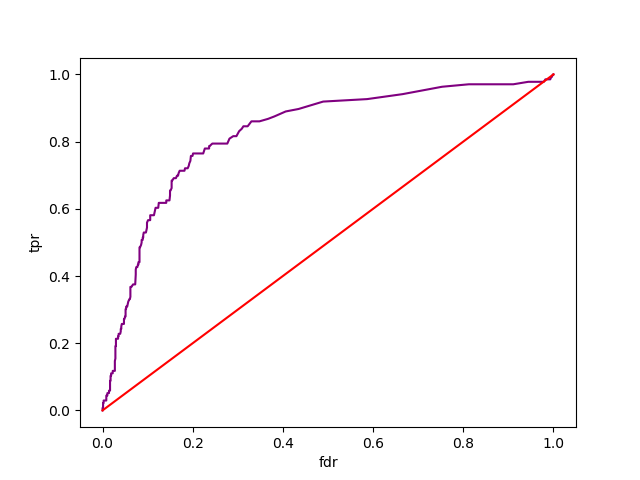

<IPython.core.display.Javascript object>


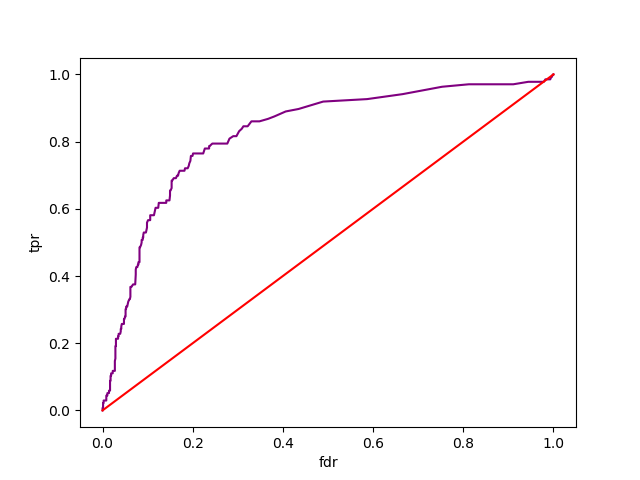

In [54]:
fig = plt.figure()
positivesLasso = []
negativesLasso = []

for i in range(len(y_predictions)):
    if (y_test[i]) < -2:
        positivesLasso.append(-y_predictions[i]*100)
    elif (y_test[i] <= 2):
        negativesLasso.append(-y_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
lassoPlot = uOrfTools.rocPlot(fig, positivesLasso, negativesLasso, color = "purple", tmin = -100, tmax = 700)
fig.savefig("rocLassoTest.png")
save_ROC("ROC_lasso.csv",positivesLasso,negativesLasso)
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

fig

### ROC plot for training data

<IPython.core.display.Javascript object>


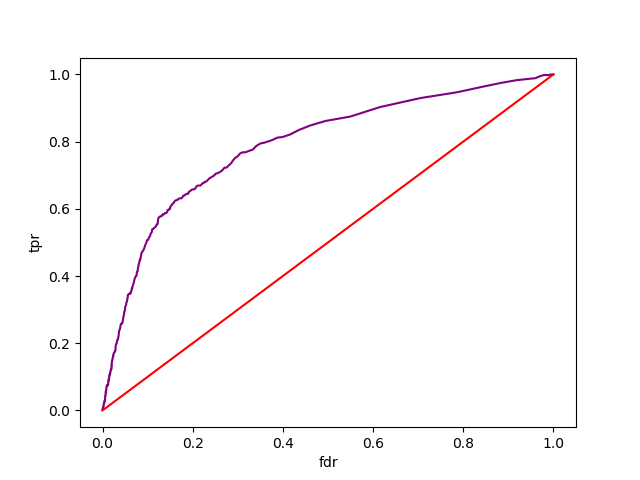

In [55]:
fig = plt.figure()
positivesLasso = []
negativesLasso = []

for i in range(len(y_train_predictions)):
    if (y_train[i]) < -2:
        positivesLasso.append(-y_train_predictions[i]*100)
    elif (y_train[i] <= 2):
        negativesLasso.append(-y_train_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
lassoPlot = uOrfTools.rocPlot(fig, positivesLasso, negativesLasso, color = "purple", tmin = -100, tmax = 700)
fig

fig.savefig("rocLassoTrain.png")
save_ROC("ROC_lasso.train.csv",positivesLasso,negativesLasso)
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

### ROC plot for all genes

In [56]:
y_test.shape, y_predictions.shape

((997,), (997,))

<IPython.core.display.Javascript object>


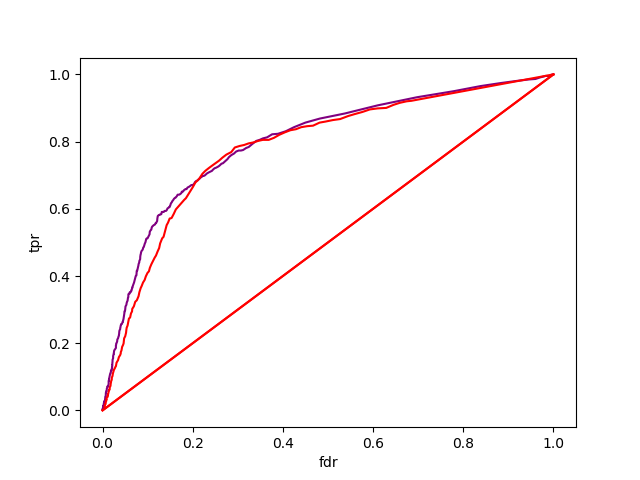

In [57]:
fig = plt.figure()
positivesLasso = []
negativesLasso = []

X = np.hstack((y_test,y_train))
Y = np.hstack((y_predictions,y_train_predictions))

for i in range(len(X)):
    if (X[i]) < -2:
        positivesLasso.append(-Y[i]*100)
    elif (X[i] <= 2):
        negativesLasso.append(-Y[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
lassoPlot = uOrfTools.rocPlot(fig, positivesLasso, negativesLasso, color = "purple", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positiveOrf, negativeOrf, color = "red", tmin = -100, tmax = 700)
fig.savefig("rocLassoAllATG.png")
save_ROC("ROC_lasso.full.csv",positivesLasso,negativesLasso)
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

<IPython.core.display.Javascript object>


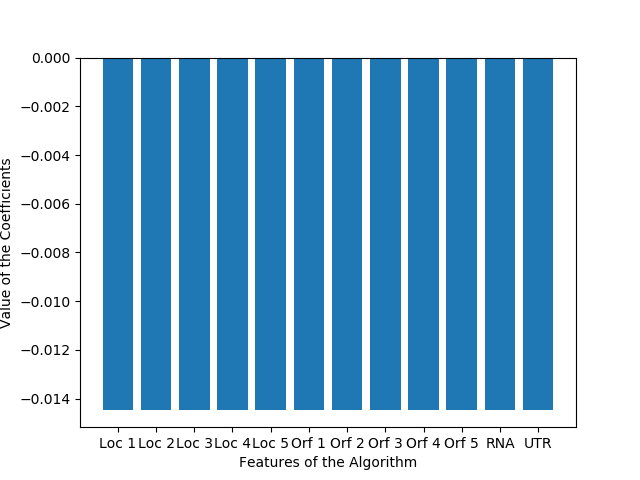

(14,)


In [58]:
x_values = ('Orf 1', 'Orf 2',
                             'Orf 3', 'Orf 4', 
                             'Orf 5', 
                             'RNA', 
                             'Loc 1', 'Loc 2',
                             'Loc 3', 'Loc 4',
                             'Loc 5', 
                             'UTR')
# y_pos = np.arange(len(x_values))
# print y_pos
# print type(y_pos) 
# y_values = model.coef_[0]
# print y_values
# print model.coef_ * 100000
fig = plt.figure()
plt.bar(x_values, lassoCV_model.coef_[0])
#plt.xticks(range(lassoCV_model.coef_.shape[1]), x_values)
#plt.xticks(y_pos, x_values)
plt.xlabel('Features of the Algorithm')
plt.ylabel('Value of the Coefficients')
plt.savefig('lassoBar.png')
print lassoCV_model.coef_.shape


### Ridge Regression

In [59]:
#Ridge regression 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, r2_score, explained_variance_score
import numpy as np
import pandas as pd

#Get all the features i.e. all the columns names
finalCols = dataFrame.columns
#Take all columns names of features except last column name which has label
finalFeatures = finalCols[:-1]
# Get values of all features
x = dataFrame.loc[:, finalFeatures].values
# Get all values of the label
y = dataFrame.loc[:,['Translation Efficiency Value']].values

print finalFeatures

#Standardize the data because the scales of the features have a large range
scaler = StandardScaler().fit(x)
x_std_data = scaler.transform(x)
#y_std_data = StandardScaler().fit_transform(y)
y_std_data = y

#Split data into test and train
x_train, x_test, y_train, y_test = train_test_split(x_std_data, y_std_data, test_size = 0.2)

#Ridge is a type of Linear Regression
#performs L2 regularization
from sklearn.linear_model import RidgeCV
ridgeCV_model = RidgeCV(alphas = [0.001,0.01,0.1,1.0,10.0],cv=5, normalize = True, scoring = 'neg_mean_squared_error')
ridgeCV_model.fit(x_train, y_train)
print('Train data coefficients', ridgeCV_model.coef_)
print('Train data alpha', ridgeCV_model.alpha_)
print ridgeCV_model


#Just look at the training metrics by using the model to predicting on itself
y_train_predictions = ridgeCV_model.predict(x_train)
print("Mean absolute error-training data: %0.2f" % mean_absolute_error(y_train, y_train_predictions))
print("Mean squared error-training data: %0.2f" % mean_squared_error(y_train, y_train_predictions))
print("Root mean squared error-training data: %0.2f" % np.sqrt(mean_squared_error(y_train, y_train_predictions)))
print("R2 score-training data: %0.2f" % r2_score(y_train, y_train_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-training data : %0.2f" % explained_variance_score(y_train, y_train_predictions))

#Predict on test data
y_predictions = ridgeCV_model.predict(x_test)
print("Mean absolute error-test data: %0.2f" % mean_absolute_error(y_test, y_predictions))
print("Mean squared error-test data : %0.2f" % mean_squared_error(y_test, y_predictions))
print("Root mean squared error-test data : %0.2f" % np.sqrt(mean_squared_error(y_test, y_predictions)))
print("R2 score-test data : %0.2f" % r2_score(y_test, y_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-test data : %0.2f" % explained_variance_score(y_test, y_predictions))


#Do Predictions on the entire data and check the metrics
ridgeCV_model.fit(x_std_data, y_std_data)
print('All data coefficients', ridgeCV_model.coef_)
print('All data alpha', ridgeCV_model.alpha_)
print ridgeCV_model
y_whole_predictions = ridgeCV_model.predict(x_std_data)
print("Mean absolute error-whole data: %0.2f" % mean_absolute_error(y_std_data, y_whole_predictions))
print("Mean squared error-whole data: %0.2f" % mean_squared_error(y_std_data, y_whole_predictions))
print("Root mean squared error-whole data: %0.2f" % np.sqrt(mean_squared_error(y_std_data, y_whole_predictions)))
print("R2 score-training data: %0.2f" % r2_score(y_std_data, y_whole_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-training data : %0.2f" % explained_variance_score(y_std_data, y_whole_predictions))


df = pd.DataFrame({'Actual':y_test.flatten(),'Predicted':y_predictions.flatten()})
print df.head(20)


Index([u'Sum of Top 5 Orf',
       u'ratio of sum length of 5 Orf to 5 prime UTR length',
       u'Top five upstream Orf 1', u'Top five upstream Orf 2',
       u'Top five upstream Orf 3', u'Top five upstream Orf 4',
       u'Top five upstream Orf 5', u'Energy of Constrained RNA structure',
       u'Location of uORF relative to 5 prime UTR 1',
       u'Location of uORF relative to 5 prime UTR 2',
       u'Location of uORF relative to 5 prime UTR 3',
       u'Location of uORF relative to 5 prime UTR 4',
       u'Location of uORF relative to 5 prime UTR 5',
       u'Length of five prime UTR'],
      dtype='object')
('Train data coefficients', array([[-0.13168642,  0.31959653, -0.00208565, -0.25993306, -0.30645867,
        -0.0789983 , -0.0673417 , -0.06020472,  0.01314856, -0.02984412,
         0.02944295,  0.07012594, -0.05749863,  0.0111857 ]]))
('Train data alpha', 0.1)
RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, fit_intercept=True,
    gcv_mode=None, normalize=True, scoring='n

### ROC plot for test data

In [60]:
y_test = y_test.flatten()
y_train = y_train.flatten()
y_predictions = y_predictions.flatten()
y_train_predictions = y_train_predictions.flatten()

<IPython.core.display.Javascript object>


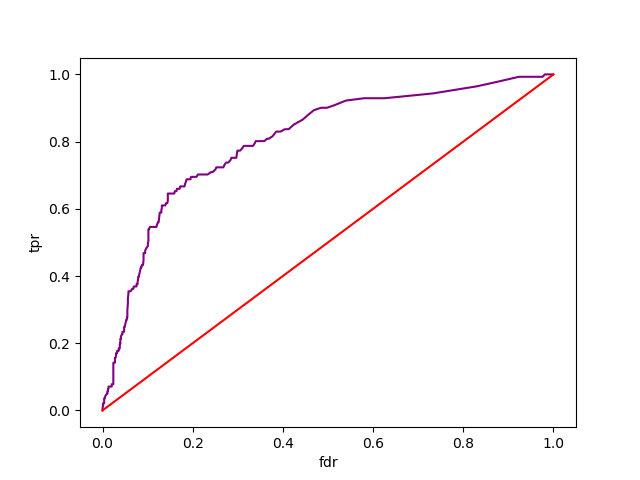

In [61]:
fig = plt.figure()
positivesRidge = []
negativesRidge = []

for i in range(len(y_predictions)):
    if (y_test[i]) < -2:
        positivesRidge.append(-y_predictions[i]*100)
    elif (y_test[i] <= 2):
        negativesRidge.append(-y_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
ridgePlot = uOrfTools.rocPlot(fig, positivesRidge, negativesRidge, color = "purple", tmin = -100, tmax = 700)
fig.savefig("rocRidgeTest.png")
save_ROC("ROC_ridge.csv",positivesRidge,negativesRidge)
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

### ROC plot for training data

<IPython.core.display.Javascript object>


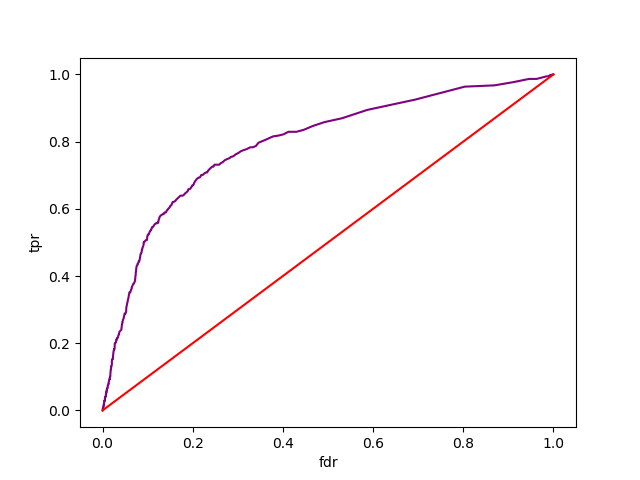

In [62]:
fig = plt.figure()
positivesRidge = []
negativesRidge = []

for i in range(len(y_train_predictions)):
    if (y_train[i]) < -2:
        positivesRidge.append(-y_train_predictions[i]*100)
    elif (y_train[i] <= 2):
        negativesRidge.append(-y_train_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
ridgePlot = uOrfTools.rocPlot(fig, positivesRidge, negativesRidge, color = "purple", tmin = -100, tmax = 700)
fig.savefig("rocRidgeTrain.png")
save_ROC("ROC_ridge.train.csv",positivesRidge,negativesRidge)
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

### ROC plot for all genes

<IPython.core.display.Javascript object>


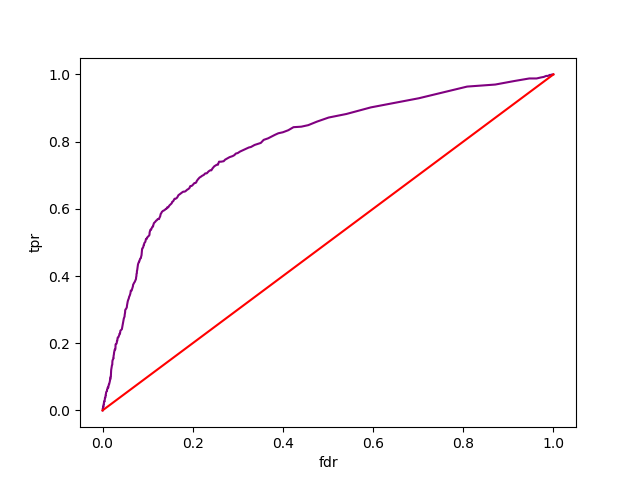

In [63]:
fig = plt.figure()
positivesRidge = []
negativesRidge = []

X = np.hstack((y_test,y_train))
Y = np.hstack((y_predictions,y_train_predictions))

for i in range(len(X)):
    if (X[i]) < -2:
        positivesRidge.append(-Y[i]*100)
    elif (X[i] <= 2):
        negativesRidge.append(-Y[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
ridgePlot = uOrfTools.rocPlot(fig, positivesRidge, negativesRidge, color = "purple", tmin = -100, tmax = 700)
fig.savefig("rocRidgeAll.png")
save_ROC("ROC_ridge.full.csv",positivesRidge,negativesRidge)
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

### SVM Linear Regression

In [64]:
#SVM Linear regression 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, r2_score, explained_variance_score
import numpy as np
import pandas as pd

#Get all the features i.e. all the columns names
finalCols = dataFrame.columns
#Take all columns names of features except last column name which has label
finalFeatures = finalCols[:-1]
# Get values of all features
x = dataFrame.loc[:, finalFeatures].values
# Get all values of the label
y = dataFrame.loc[:,['Translation Efficiency Value']].values

print finalFeatures

#Standardize the data because the scales of the features have a large range
scaler = StandardScaler().fit(x)
x_std_data = scaler.transform(x)
#y_std_data = StandardScaler().fit_transform(y)
y_std_data = y

#Split data into test and train
x_train, x_test, y_train, y_test = train_test_split(x_std_data, y_std_data, test_size = 0.2)

#SVM linear regressor
from sklearn.svm import SVR
svm_linear_reg = SVR(kernel = "linear", C = 4.0, epsilon = 0.2)
svm_linear_reg.fit(x_train, y_train)
print('Train data coefficients', svm_linear_reg.coef_)
print svm_linear_reg


#Just look at the training metrics by using the model to predicting on itself
y_train_predictions = svm_linear_reg.predict(x_train)
print("Mean absolute error-training data: %0.2f" % mean_absolute_error(y_train, y_train_predictions))
print("Mean squared error-training data: %0.2f" % mean_squared_error(y_train, y_train_predictions))
print("Root mean squared error-training data: %0.2f" % np.sqrt(mean_squared_error(y_train, y_train_predictions)))
print("R2 score-training data: %0.2f" % r2_score(y_train, y_train_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-training data : %0.2f" % explained_variance_score(y_train, y_train_predictions))

#Predict on test data
y_predictions = ridgeCV_model.predict(x_test)
print("Mean absolute error-test data: %0.2f" % mean_absolute_error(y_test, y_predictions))
print("Mean squared error-test data : %0.2f" % mean_squared_error(y_test, y_predictions))
print("Root mean squared error-test data : %0.2f" % np.sqrt(mean_squared_error(y_test, y_predictions)))
print("R2 score-test data : %0.2f" % r2_score(y_test, y_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-test data : %0.2f" % explained_variance_score(y_test, y_predictions))


#Do Predictions on the entire data and check the metrics
svm_linear_reg.fit(x_std_data, y_std_data)
print('All data coefficients', svm_linear_reg.coef_)
print svm_linear_reg
y_whole_predictions = svm_linear_reg.predict(x_std_data)
print("Mean absolute error-whole data: %0.2f" % mean_absolute_error(y_std_data, y_whole_predictions))
print("Mean squared error-whole data: %0.2f" % mean_squared_error(y_std_data, y_whole_predictions))
print("Root mean squared error-whole data: %0.2f" % np.sqrt(mean_squared_error(y_std_data, y_whole_predictions)))
print("R2 score-training data: %0.2f" % r2_score(y_std_data, y_whole_predictions, multioutput = 'variance_weighted'))
print("Explained variance score-training data : %0.2f" % explained_variance_score(y_std_data, y_whole_predictions))


df = pd.DataFrame({'Actual':y_test.flatten(),'Predicted':y_predictions.flatten()})
print df.head(20)


Index([u'Sum of Top 5 Orf',
       u'ratio of sum length of 5 Orf to 5 prime UTR length',
       u'Top five upstream Orf 1', u'Top five upstream Orf 2',
       u'Top five upstream Orf 3', u'Top five upstream Orf 4',
       u'Top five upstream Orf 5', u'Energy of Constrained RNA structure',
       u'Location of uORF relative to 5 prime UTR 1',
       u'Location of uORF relative to 5 prime UTR 2',
       u'Location of uORF relative to 5 prime UTR 3',
       u'Location of uORF relative to 5 prime UTR 4',
       u'Location of uORF relative to 5 prime UTR 5',
       u'Length of five prime UTR'],
      dtype='object')


/usr/lib/python2.7/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


('Train data coefficients', array([[-0.07061946,  0.02623415,  0.13112857, -0.19809287, -0.39584328,
         0.05082011, -0.2198757 , -0.07121839, -0.05181232, -0.09618948,
        -0.01734533,  0.15948281, -0.00542308, -0.1872972 ]]))
SVR(C=4.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Mean absolute error-training data: 1.16
Mean squared error-training data: 2.89
Root mean squared error-training data: 1.70
R2 score-training data: 0.17
Explained variance score-training data : 0.19
Mean absolute error-test data: 1.29
Mean squared error-test data : 3.35
Root mean squared error-test data : 1.83
R2 score-test data : 0.11
Explained variance score-test data : 0.11
('All data coefficients', array([[-0.06676031,  0.02559791,  0.18155881, -0.28414304, -0.43212104,
         0.1009693 , -0.21101307, -0.05600919, -0.07785275, -0.05568644,
        -0.0049264 ,  0.17998165, -0.01865002, -0.19863634]]))


### ROC plot for test data - SVM Linear Regression

In [65]:
y_test = y_test.flatten()
y_train = y_train.flatten()
y_predictions = y_predictions.flatten()
y_train_predictions = y_train_predictions.flatten()

<IPython.core.display.Javascript object>


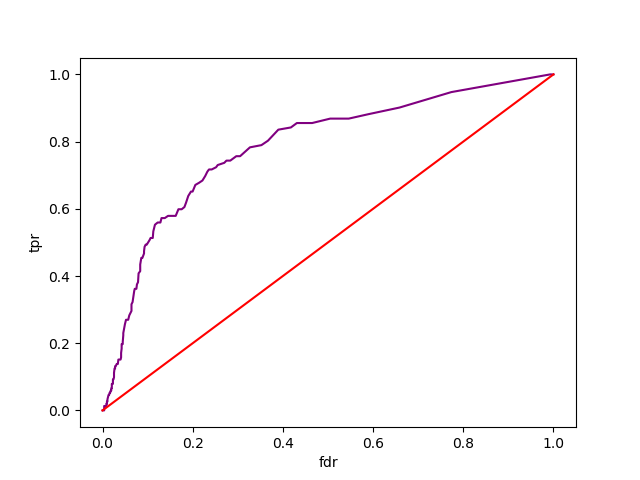

In [66]:
fig = plt.figure()
positivesSVMLinear = []
negativesSVMLinear = []

for i in range(len(y_predictions)):
    if (y_test[i]) < -2:
        positivesSVMLinear.append(-y_predictions[i]*100)
    elif (y_test[i] <= 2):
        negativesSVMLinear.append(-y_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
svmLinearPlot = uOrfTools.rocPlot(fig, positivesSVMLinear, negativesSVMLinear, color = "purple", tmin = -100, tmax = 700)
fig.savefig("rocSVMLinearTest.png")
save_ROC("ROC_svm_linear.csv",positivesSVMLinear,negativesSVMLinear)
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

### ROC plot for training data - SVM Linear Regression

<IPython.core.display.Javascript object>


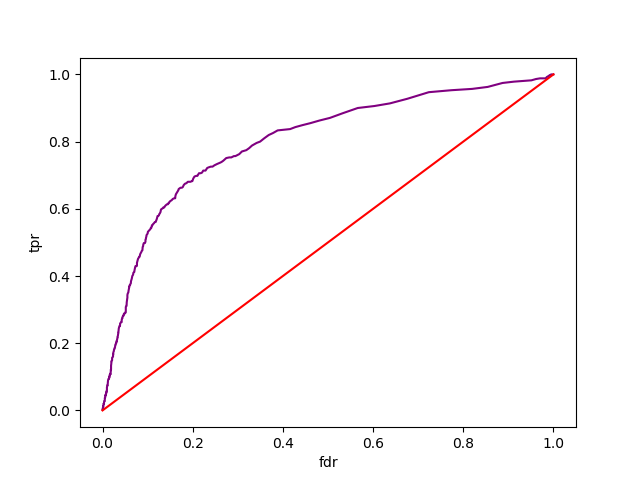

In [67]:
fig = plt.figure()
positivesSVMLinear = []
negativesSVMLinear = []

for i in range(len(y_train_predictions)):
    if (y_train[i]) < -2:
        positivesSVMLinear.append(-y_train_predictions[i]*100)
    elif (y_train[i] <= 2):
        negativesSVMLinear.append(-y_train_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
svmLinearPlot = uOrfTools.rocPlot(fig, positivesSVMLinear, negativesSVMLinear, color = "purple", tmin = -100, tmax = 700)
fig.savefig("rocSVMLinearTrain.png")
save_ROC("ROC_svm_linear.train.csv",positivesSVMLinear,negativesSVMLinear)
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

### ROC plot for all genes - SVM Linear Regression

/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


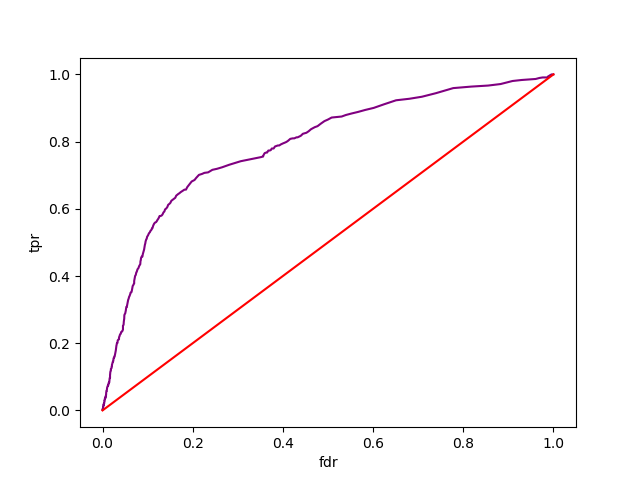

In [68]:
fig = plt.figure()
positivesSVMLinear = []
negativesSVMLinear = []

X = np.hstack((y_test,y_train))
Y = np.hstack((y_predictions,y_train_predictions))

for i in range(len(X)):
    if (X[i]) < -2:
        positivesSVMLinear.append(-Y[i]*100)
    elif (X[i] <= 2):
        negativesSVMLinear.append(-Y[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
svmLinearPlot = uOrfTools.rocPlot(fig, positivesSVMLinear, negativesSVMLinear, color = "purple", tmin = -100, tmax = 700)
fig.savefig("rocSVMLinearAll.png")
save_ROC("ROC_svm_linear.full.csv",positivesSVMLinear,negativesSVMLinear)
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

In [79]:
#Random Forest regressor grid search for best hyper parameters
#Ignore warnings about ravel data like the ones below
#Please change the shape of y to (n_samples,), for example using ravel().
#because they take up too much space and distract my attention from the real values that I try to print
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Get all the features i.e. all the columns names
finalCols = dataFrame.columns
#Take all columns names of features except last column name which has label
finalFeatures = finalCols[:-1]
# Get values of all features
x = dataFrame.loc[:, finalFeatures].values
# Get all values of the label
y = dataFrame.loc[:,['Translation Efficiency Value']].values

print(finalFeatures)

#Stanardize the data because the scales of the features have a large range
scaler = StandardScaler().fit(x)
x_std_data = scaler.transform(x)
# y_std_data = y.round(1)
y_std_data = y


#####KEEP COMMENTED UNLESS YOU WANT TO RUN IT BECAUSE IT TAKES ABOUT 2 HOURS TO RUN
#Split data into test and train
# x_train, x_test, y_train, y_test = train_test_split(x_std_data, y_std_data, test_size = 0.33)  
# from sklearn.model_selection import GridSearchCV
# param_grid = [{'n_estimators':[10,30,60,80,100],'max_features':[2,4,6,8], \
#                'max_depth':[20,40,60,80,100], 'bootstrap':[True,False], \
#                'min_samples_split':[2,5,10], 'min_samples_leaf':[1,2,4]\
#               }]
# forest_reg_GSCV = RandomForestRegressor(warm_start=True)
# grid_search = GridSearchCV(forest_reg_GSCV, param_grid, 
#                            cv = 5, scoring = 'neg_mean_squared_error')
# grid_search.fit(x_std_data,y_std_data)
# print(grid_search.best_params_)
# print(grid_search.best_estimator_)
# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
#     print(np.sqrt(-mean_score), params)

Index([u'Sum of Top 5 Orf',
       u'ratio of sum length of 5 Orf to 5 prime UTR length',
       u'Top five upstream Orf 1', u'Top five upstream Orf 2',
       u'Top five upstream Orf 3', u'Top five upstream Orf 4',
       u'Top five upstream Orf 5', u'Energy of Constrained RNA structure',
       u'Location of uORF relative to 5 prime UTR 1',
       u'Location of uORF relative to 5 prime UTR 2',
       u'Location of uORF relative to 5 prime UTR 3',
       u'Location of uORF relative to 5 prime UTR 4',
       u'Location of uORF relative to 5 prime UTR 5',
       u'Length of five prime UTR'],
      dtype='object')


('max TE:', 3.0515941095532138)
('min TE:', -9.459208043198533)
The outputs
('Test mean r2:', 0.46231420576179122)
('Test median r2:', 0.46692131401958858)
('Test mean rmse:', 1.3867982865692494)
('Test median rmse:', 1.3808935944408858)
('Train mean r2:', 0.46755504363151501)
('Train median r2:', 0.46669138931517729)
('Train mean rmse:', 1.3733551187565474)
('Train median rmse:', 1.3751311341736157)


<IPython.core.display.Javascript object>


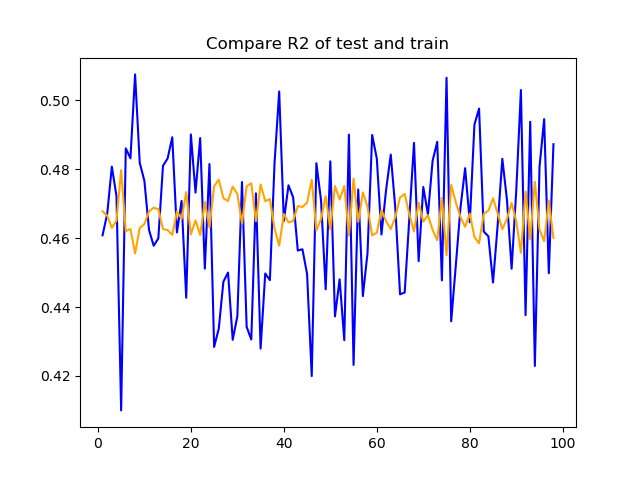

<IPython.core.display.Javascript object>


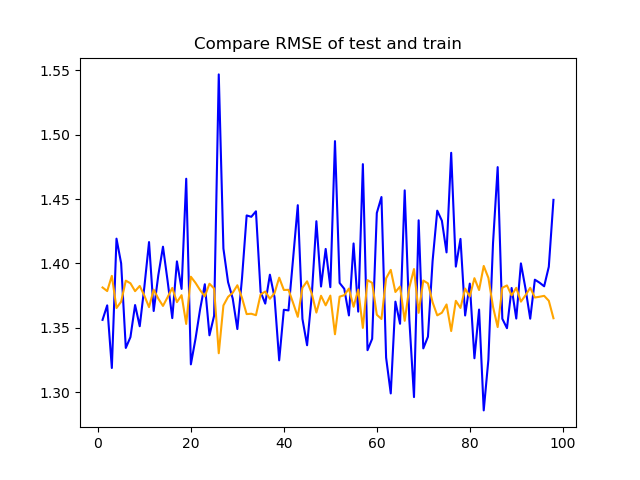

('Minimum R2 Test:', 0.41000809508704272)
('Minimum R2 Train:', 0.45502927075739164)
('Max R2 Test:', 0.50757257947178291)
('Max R2 Train:', 0.47977673066782434)
('Minimum RMSE Test:', 1.2857728933502619)
('Minimum RMSE Train:', 1.3301809256886155)
('Max RMSE Test:', 1.5468667048558475)
('Max RMSE Train:', 1.3980211375788854)
     Actual  Predicted
0 -5.098989  -3.559090
1  1.237645  -2.331960
2  0.141527   0.017132
3  1.281804   0.116198
4 -0.238294  -1.084051
5  1.343217   0.480973
6  0.205871  -1.089596
7  0.778630   0.890033
8 -0.930806  -0.722949
9 -1.169058  -0.661366


In [83]:
# Gridsearch gives us the best estimator as
# RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
#            max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
#            min_impurity_split=None, min_samples_leaf=4,
#            min_samples_split=10, min_weight_fraction_leaf=0.0,
#            n_estimators=80, n_jobs=None, oob_score=False,
#            random_state=None, verbose=0, warm_start=True)
#Random Forest regressor
#Ignore warnings about ravel data like the ones below
#Please change the shape of y to (n_samples,), for example using ravel().
#because they take up too much space and distract my attention from the real values that I try to print
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import numpy as np

#Get all the features i.e. all the columns names
finalCols = dataFrame.columns
#Take all columns names of features except last column name which has label
finalFeatures = finalCols[:-1]
# Get values of all features
x = dataFrame.loc[:, finalFeatures].values
# Get all values of the label
y = dataFrame.loc[:,['Translation Efficiency Value']].values


#Standardize the data because the scales of the features have a large range
scaler = StandardScaler().fit(x)
x_std_data = scaler.transform(x)
y_std_data = y
print("max TE:", np.max(y))
print("min TE:", np.min(y))

rmse_val = [] #to store rmse test values for different runs
r2=[] #to store r2 test values for different runs
ev=[]
y_preds=[]
rmse_train=[]
r2_train=[]
ev_train=[]
y_train_preds=[]

####Random Forest Regressor
rf_model = RandomForestRegressor(bootstrap=True,warm_start=True, min_samples_leaf=4,
                                n_estimators=80,min_samples_split=10,max_features=2,max_depth=60)

#########
##DO 100 RUNS of Random forest regressor predictions then plot the variation in RMSE AND r2
## Will give an idea of the variance in RMSE AND R2
########
for K in range(1,100):
    x_train, x_test, y_train, y_test = train_test_split(x_std_data, y_std_data, test_size = 0.2)
    rf_model.fit(x_train, y_train.ravel())  #fit the model
    y_predictions=rf_model.predict(x_test) #make prediction on test set
    #for test data
    error = np.sqrt(mean_squared_error(y_test,y_predictions)) #calculate rmse
    r2.append(r2_score(y_test, y_predictions, multioutput = 'variance_weighted'))
    ev.append(explained_variance_score(y_test, y_predictions))
    rmse_val.append(error) 
    y_preds.append(y_predictions)
    #for train data
    y_train_predictions = rf_model.predict(x_train) #make prediction on train set
    rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_predictions))) 
    r2_train.append(r2_score(y_train, y_train_predictions, multioutput = 'variance_weighted'))
    ev_train.append(explained_variance_score(y_train, y_train_predictions))   
    y_train_preds.append(y_train_predictions)
    K = K+1


#TODO later:check to what extent weights are most prominent
#throw out the factors it is not making use on
#do we do as well
#Do prints to check the values
print("The outputs")
print("Test mean r2:", np.mean(r2))
print("Test median r2:", np.median(r2))
print("Test mean rmse:", np.mean(rmse_val))
print("Test median rmse:", np.median(rmse_val))
print("Train mean r2:", np.mean(r2_train))
print("Train median r2:", np.median(r2_train))
print("Train mean rmse:", np.mean(rmse_train))
print("Train median rmse:", np.median(rmse_train))

#Create plots to see how RMSE and R2 vary between test and train data
xAxis = []
r2_yAxis =[]
r2_train_yAxis =[]
rmse_yAxis =[]
rmse_train_yAxis =[]
for i in range(1, 99):
    #print("Test r2:", r2[i], "Train r2:", r2_train[i], "Test RMSE:", rmse_val[i], "Train RMSE:", rmse_train[i])
    xAxis.append(i)
    r2_yAxis.append(r2[i])
    r2_train_yAxis.append(r2_train[i])
    rmse_yAxis.append(rmse_val[i])
    rmse_train_yAxis.append(rmse_train[i])

fig = plt.figure()
plt.title("Compare R2 of test and train")
plt.plot(xAxis,r2_yAxis, color = 'blue')
plt.plot(xAxis,r2_train_yAxis, color = 'orange')
fig = plt.figure()
plt.title("Compare RMSE of test and train")
plt.plot(xAxis,rmse_yAxis, color = 'blue')
plt.plot(xAxis,rmse_train_yAxis, color = 'orange')

print("Minimum R2 Test:", np.min(r2_yAxis))
print("Minimum R2 Train:", np.min(r2_train_yAxis))
print("Max R2 Test:", np.max(r2_yAxis))
print("Max R2 Train:", np.max(r2_train_yAxis))
print("Minimum RMSE Test:", np.min(rmse_yAxis))
print("Minimum RMSE Train:", np.min(rmse_train_yAxis))
print("Max RMSE Test:", np.max(rmse_yAxis))
print("Max RMSE Train:", np.max(rmse_train_yAxis))

df = pd.DataFrame({'Actual':y_test.flatten(),'Predicted':y_predictions.flatten()})
print(df.head(10))

<IPython.core.display.Javascript object>


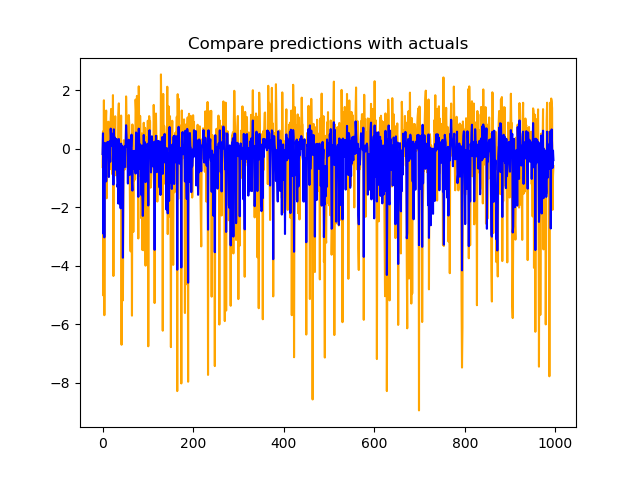

In [81]:
###Put this in new cell###
fig = plt.figure()
plt.title("Compare predictions with actuals")
x_axis = []
for i in range(0,len(y_predictions)):
    x_axis.append(i)
plt.plot(x_axis,y_test.flatten(), color = 'orange')
plt.plot(x_axis,y_predictions.flatten(), color = 'blue')

<IPython.core.display.Javascript object>


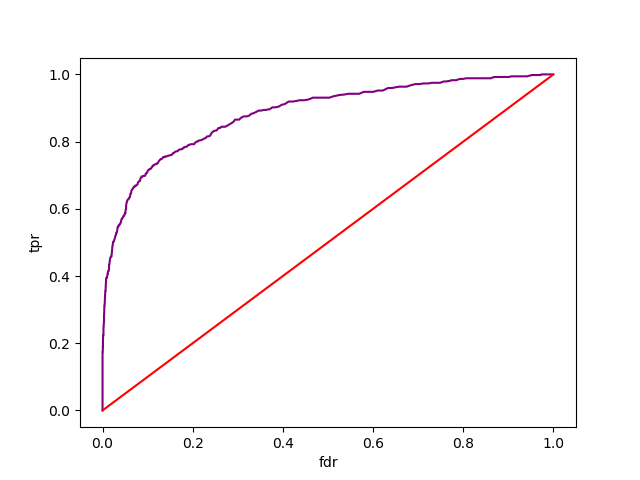

In [84]:
#train
#ROC plot for Random Forest Regressor 
fig = plt.figure()
positivesForest = []
negativesForest = []

for i in range(len(y_train_predictions)):
    if (y_train[i]) < -2:
        positivesForest.append(-y_train_predictions[i]*100)
    elif (y_train[i] <= 2):
        negativesForest.append(-y_train_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
treePlot = uOrfTools.rocPlot(fig, positivesForest, negativesForest, color = "purple", tmin = -100, tmax = 700)
save_ROC("ROC_rForest.train.csv",positivesForest,negativesForest)
fig.savefig("rocForestTrain.png")
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

<IPython.core.display.Javascript object>


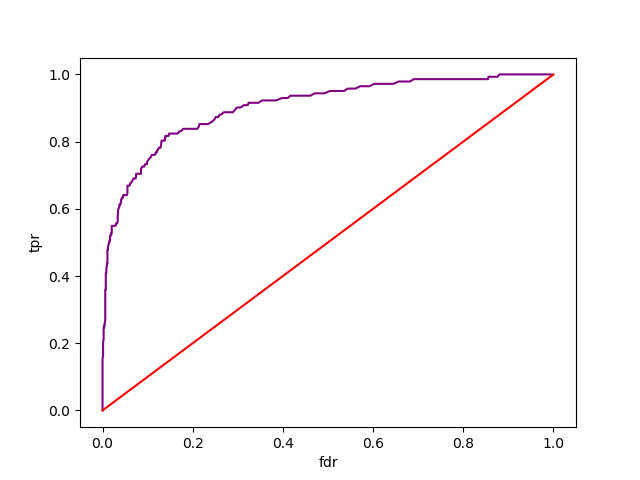

In [85]:
#testing
#ROC plot for Random Forest Regressor 
fig = plt.figure()
positivesForest = []
negativesForest = []

for i in range(len(y_predictions)):
    if (y_test[i]) < -2:
        positivesForest.append(-y_predictions[i]*100)
    elif (y_test[i] <= 2):
        negativesForest.append(-y_predictions[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
        
treePlot = uOrfTools.rocPlot(fig, positivesForest, negativesForest, color = "purple", tmin = -100, tmax = 700)
save_ROC("ROC_Forest.csv",positivesForest,negativesForest)
fig.savefig("rocForestTest.png")
#fig2 = plt.figure()
#b = plt.boxplot((positives,negatives))

#fig

In [86]:
y_train = y_train.flatten()
y_test = y_test.flatten()
y_predictions = y_predictions.flatten()
y_train_predictions = y_train_predictions.flatten()

<IPython.core.display.Javascript object>


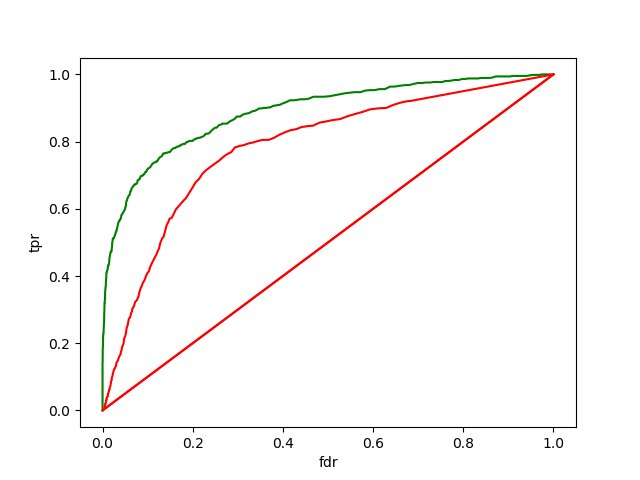

In [87]:
#random forest roc plot
fig = plt.figure()
positivesForest = []
negativesForest = []
X = np.hstack((y_train,y_test))
Y = np.hstack((y_train_predictions,y_predictions))

for i in range(len(X)):
    if (X[i] < -2):
        #Question for Dr. Voorhies: why should I take -ve of y_predictions
        positivesForest.append(-Y[i]*100)
    elif (X[i] <=2):
        negativesForest.append(-Y[i]*100)
        
#print(len(set(positives)), len(set(negatives)))
#print len(positives)
#print len(negatives)
        
forestPlot = uOrfTools.rocPlot(fig, positivesForest, negativesForest, color = "green", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positiveOrf, negativeOrf, color = "red", tmin = -100, tmax = 700)
fig.savefig("rocForestAll.png")
save_ROC("ROC_forest.full.csv",positives,negatives)

In [74]:
#Do cross fold validation for different algorithms
#Cross validation

def display_scores(rmse_score):
    print("score:", rmse_score)
    print("mean:", rmse_score.mean())
    print("standard deviation:", rmse_score.std())

print np.max(y_std_data)
print np.min(y_std_data)

#cv random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import numpy as np
from sklearn.model_selection import cross_val_score
forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, x_std_data, \
                         y_std_data, scoring = 'neg_mean_squared_error', cv = 5)
rmse_score = np.sqrt(-scores)    
print "Random Forest Regressor CV results" 
display_scores(rmse_score)
print forest_reg

#cv decision tree
tree_reg = DecisionTreeRegressor(max_depth=2)
scores = cross_val_score(tree_reg, x_std_data, 
                         y_std_data, scoring = 'neg_mean_squared_error', cv = 5)
rmse_score = np.sqrt(-scores)    
print "Decision Tree Regressor CV results" 
display_scores(rmse_score)
print tree_reg

#cv linear regression
linear_reg = LinearRegression()
scores = cross_val_score(linear_reg, x_std_data, \
                         y_std_data, scoring = 'neg_mean_squared_error', cv = 5)
rmse_score = np.sqrt(-scores)    
print "Linear Regressor CV results" 
display_scores(rmse_score)
print(linear_reg)
print linear_reg

#cv ridge
#lasso_reg = linear_model.Lasso(alpha = 0.00042887)
ridge_reg = linear_model.Ridge(alpha = 0.01, normalize = True)
scores = cross_val_score(ridge_reg, x_std_data, \
                         y_std_data, scoring = 'neg_mean_squared_error', cv = 5)
rmse_score = np.sqrt(-scores)    
print "Ridge Regressor CV results" 
display_scores(rmse_score)
print ridge_reg

#cv lasso
lasso_reg = linear_model.Lasso(alpha = 0.00042887)
scores = cross_val_score(lasso_reg, x_std_data, \
                         y_std_data, scoring = 'neg_mean_squared_error', cv = 5)
rmse_score = np.sqrt(-scores)    
print "Lasso Regressor CV results" 
display_scores(rmse_score)
print lasso_reg

#cv svm linear
from sklearn.svm import SVR

svm_linear_reg = SVR(kernel = "linear", C = 10.0, epsilon = 0.2)
scores = cross_val_score(svm_linear_reg, x_std_data, \
                         y_std_data.ravel(), scoring = 'neg_mean_squared_error', cv = 5)
rmse_score = np.sqrt(-scores)    
print "SVM Linear Regressor CV results" 
display_scores(rmse_score)
print svm_linear_reg

#cv svm poly
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel = "poly", degree = 2, C = 10.0, epsilon = 0.2)
scores = cross_val_score(svm_poly_reg, x_std_data, \
                         y_std_data.ravel(), scoring = 'neg_mean_squared_error', cv = 5)
rmse_score = np.sqrt(-scores)    
print "SVM Poly Regressor CV results" 
display_scores(rmse_score)
print svm_poly_reg

#cv svm sigmoid
from sklearn.svm import SVR

svm_sigmoid_reg = SVR(kernel = "sigmoid", C = 1.0, epsilon = 0.2)
scores = cross_val_score(svm_sigmoid_reg, x_std_data, \
                         y_std_data.ravel(), scoring = 'neg_mean_squared_error', cv = 5)
rmse_score = np.sqrt(-scores)    
print "SVM Sigmoid Regressor CV results" 
display_scores(rmse_score)
print svm_sigmoid_reg

#cv svm default
from sklearn.svm import SVR

svm_reg = SVR(C = 10.0, epsilon = 0.2)
scores = cross_val_score(svm_reg, x_std_data, \
                         y_std_data.ravel(), scoring = 'neg_mean_squared_error', cv = 5)
rmse_score = np.sqrt(-scores)    
print "SVM Default Regressor CV results" 
display_scores(rmse_score)
print svm_reg

3.05159410955
-9.4592080432


/usr/lib/python2.7/dist-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Random Forest Regressor CV results
('score:', array([ 4.10804895,  1.21959758,  1.1904003 ,  1.39087015,  2.27044338]))
('mean:', 2.0358720729263409)
('standard deviation:', 1.1087014698122186)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Decision Tree Regressor CV results
('score:', array([ 4.07959979,  1.05183738,  0.90895437,  1.23344766,  2.12466649]))
('mean:', 1.8797011354877877)
('standard deviation:', 1.1785510884755532)
DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_

/usr/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso Regressor CV results
('score:', array([ 4.11130381,  1.01828394,  0.7977997 ,  1.30605511,  2.12144106]))
('mean:', 1.8709767246503239)
('standard deviation:', 1.2066257209280766)
Lasso(alpha=0.00042887, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
SVM Linear Regressor CV results
('score:', array([ 4.07571041,  1.21182335,  0.8385963 ,  1.1473919 ,  1.90475297]))
('mean:', 1.8356549868596104)
('standard deviation:', 1.1729979418180003)
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVM Poly Regressor CV results
('score:', array([  4.19668951,   1.63258894,   1.01633682,   1.1647425 ,  15.23121718]))
('mean:', 4.6483149887588313)
('standard deviation:', 5.4152180133443393)
SVR(C=10.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.2, gamma='auto',
  ker

In [75]:
utrList = load_ROC("ROC_utr.csv")

positiveutr = utrList[0]
negativeutr = utrList[1]

orfList = load_ROC("uOrfTEATG.csv")

positiveOrf = orfList[0]
negativeOrf = orfList[1]

orfNoATGList = load_ROC("uOrfTENoATG.csv")

positiveOrfNoATG = orfNoATGList[0]
negativeOrfNoATG = orfNoATGList[1]


<IPython.core.display.Javascript object>


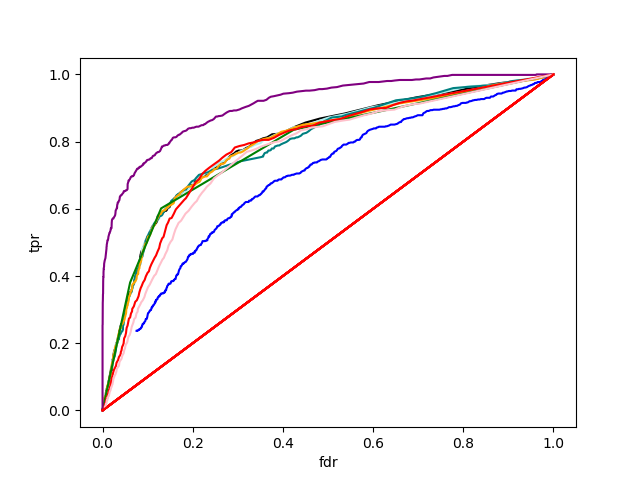

In [76]:
fig = plt.figure()
uOrfTools.rocPlot(fig, positivesLasso, negativesLasso, color = "black", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positivesRidge, negativesRidge, color = "#afeeee", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positivesSVMLinear, negativesSVMLinear, color = "teal", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positives, negatives, color = "orange", tmin = -100, tmax = 700) #linear regression
uOrfTools.rocPlot(fig, positivesTree, negativesTree, color = "green", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positiveutr, negativeutr, color = "blue", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positivesForest, negativesForest, color = "purple", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positiveOrf, negativeOrf, color = "red", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positiveOrfNoATG, negativeOrfNoATG, color = "pink", tmin = -100, tmax = 700)
fig.savefig("presAllPlot.png")
#fig

<IPython.core.display.Javascript object>


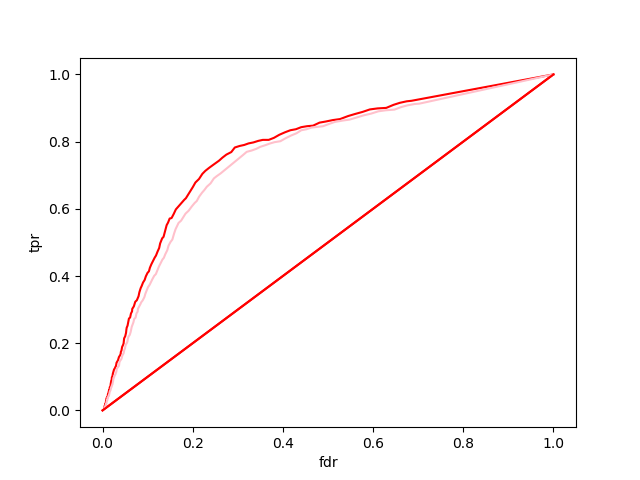

In [77]:
fig = plt.figure()
uOrfTools.rocPlot(fig, positiveOrf, negativeOrf, color = "red", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positiveOrfNoATG, negativeOrfNoATG, color = "pink", tmin = -100, tmax = 700)
fig
fig.savefig("orfATGComparison.png")

<IPython.core.display.Javascript object>


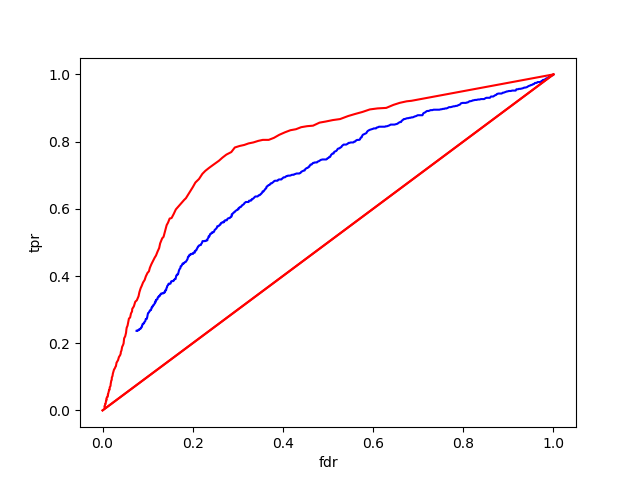

In [78]:
fig = plt.figure()
uOrfTools.rocPlot(fig, positiveutr, negativeutr, color = "blue", tmin = -100, tmax = 700)
uOrfTools.rocPlot(fig, positiveOrf, negativeOrf, color = "red", tmin = -100, tmax = 700)
fig.savefig("utrOrfComparison.png")